# Sentiment Analysis : US Election 2020 Tweets (Trump vs Biden)

In [ ]:
!pip install pycld2
!pip install -q kaggle

In [ ]:
#Importing Necessary Libraries

import numpy as np
import pandas as pd

#NLP Library

import spacy
import re

#Language Detect Library
import pycld2 as cld2

#Feature extraction, model selection and model training library
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split


#Libraries to check the model performance
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Graphing Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as snb
from wordcloud import WordCloud, STOPWORDS

#Hypothesis Testing
import math
from scipy.stats import chi2_contingency, chisquare, chi2

#HTML Enscraping
import html

## Data Collection

In [ ]:
# #Input Files

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [ ]:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mv: kaggle.json: No such file or directory


In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
import zipfile
import tarfile
import shutil
from IPython.display import HTML, display
import time

!mkdir -p ~/.kaggle
!kaggle datasets download -d kazanova/sentiment140
!kaggle datasets download -d manchunhui/us-election-2020-tweets

archive_path = '/Users/logeshwaraninbaraj/Downloads/us-election-2020-tweets.zip'
content_path = '/Users/logeshwaraninbaraj/Downloads'

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
  zip_ref.extractall(content_path)

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, 100), display_id=True)
for ii in range(101):
    time.sleep(0.02)
    out.update(progress(ii, 100))




print('Data Sets Downloaded and Extracted')

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)
us-election-2020-tweets.zip: Skipping, found more recently modified local copy (use --force to force download)


Data Sets Downloaded and Extracted


In [ ]:
# Specifying the Path to the Dataset
file_path1 = '/Users/logeshwaraninbaraj/Downloads/sentiment140.zip'
file_path2 = '/Users/logeshwaraninbaraj/Downloads/hashtag_donaldtrump.csv'
file_path3 = '/Users/logeshwaraninbaraj/Downloads/hashtag_joebiden.csv'

# Loading the Training Dataset into a Pandas DataFrame
train_tweets = pd.read_csv(file_path1, encoding='ISO-8859-1')

# LoadING the Testing Dataset into a Pandas DataFrame
test_tweets_1 = pd.read_csv(file_path2, lineterminator='\n')
test_tweets_2 = pd.read_csv(file_path3, lineterminator='\n')

In [ ]:
# Assigning Column Names to Training Dataset

train_tweets.columns = ["label", "time", "date", "query", "username", "text"]

In [ ]:
train_tweets.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
test_tweets_1.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [ ]:
test_tweets_2.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


## Data Cleaning

In [ ]:
# Loading Spacy's Small Language Model for Cleaning the Tweets

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [ ]:
# Function to clean the tweet using Regex

def clean_tweet_text_regex(tweet):
    tweet = html.unescape(tweet)
    tweet = tweet.lower() # to lower case
    tweet = re.sub(r"@[A-Za-z0-9]+","", tweet) # Remove @Mentions
    tweet = re.sub(r"#","", tweet) # remove # \ART[\s]+
    tweet = re.sub(r"\ART[\s]+","", tweet) # Remove RT in start
    tweet = re.sub(r"https?:\/\/\S+","", tweet) # Remove hyperlink
    tweet = re.sub("(.)\\1{2,}","\\1", tweet) # Remove more than one characters.
    tweet = re.sub(r"[^A-Za-z0-9\s]+", "",str(tweet)) #remove special characters "!"

    return tweet

In [ ]:
# Function to clean the tweet using spacy

def clean_tweet_spacy_core(doc):
    tokens= []

    for token in doc:
        if token.is_stop:
            continue
        if token.text != token.lemma_:
            tokens.append(token.lemma_)
        else:
            tokens.append(token.text)


    tweet=" ".join(tokens)
    return tweet

In [ ]:
def doc_to_spans(list_of_texts, join_string=' ||| '):
    all_docs = nlp(' ||| '.join(list_of_texts))
    split_inds = [i for i, token in enumerate(all_docs) if token.text == '|||'] + [len(all_docs)]
    new_docs = [all_docs[(i + 1 if i > 0 else i):j] for i, j in zip([0] + split_inds[:-1], split_inds)]
    all_docs = None
    return new_docs

def get_complete_spans(data,colname):
    splitted_frames = np.array_split(data, 500)
    docs=[]
    i = 1
    for frame in splitted_frames:
        docs.append(doc_to_spans(frame[colname]))
    return docs

In [ ]:
def clean_tweet_spacy(data, colname):
    docs = get_complete_spans(data, colname)

    print("Tweets cleaning started")
    tweets = []

    for doces in docs:
        for doc in doces:
            tweets.append(clean_tweet_spacy_core(doc))

    print("Tweets cleaned")
    return tweets

In [ ]:
# Definition to detect language

def detect_lang(tweet):
    try:
        isReliable, textBytesFound, details = cld2.detect(tweet)
        return details[0][0]
    except:
        return "not found"

In [ ]:
test_tweets_1['regex_cleaned'] = test_tweets_1['tweet'].apply(clean_tweet_text_regex)

In [ ]:
test_tweets_1['cleaned_tweet'] = clean_tweet_spacy(test_tweets_1,'regex_cleaned')

Tweets cleaning started
Tweets cleaned


In [ ]:
test_tweets_1['lang'] = test_tweets_1['tweet'].apply(detect_lang)

In [ ]:
test_tweets_1.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,long,city,country,continent,state,state_code,collected_at,regex_cleaned,cleaned_tweet,lang
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,elecciones2020 en florida joebiden dice que d...,elecciones2020 en florida joebiden dice que ...,SPANISH
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,usa 2020 trump contro facebook e twitter copro...,usa 2020 trump contro facebook e twitter copro...,ENGLISH
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,trump as a student i used to hear for years fo...,trump student hear year year hear china 2019 1...,ENGLISH
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,2 hours since last tweet from trump maybe he i...,2 hour tweet trump maybe busy tremendously busy,ENGLISH
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,you get a tie and you get a tie trump s rally ...,tie tie trump s rally iowa,ENGLISH


In [ ]:
test_tweets_2['regex_cleaned'] = test_tweets_2['tweet'].apply(clean_tweet_text_regex)

In [ ]:
test_tweets_2['cleaned_tweet'] = clean_tweet_spacy(test_tweets_2,'regex_cleaned')

Tweets cleaning started
Tweets cleaned


In [ ]:
test_tweets_2['lang'] = test_tweets_2['tweet'].apply(detect_lang)

In [ ]:
test_tweets_2.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,long,city,country,continent,state,state_code,collected_at,regex_cleaned,cleaned_tweet,lang
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,elecciones2020 en florida joebiden dice que d...,elecciones2020 en florida joebiden dice que ...,SPANISH
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,hunterbiden hunterbidenemails joebiden joebide...,hunterbiden hunterbidenemail joebiden joebiden...,ENGLISH
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566,this is how biden made his trumpisnotamerica \n,biden trumpisnotamerica \n,ENGLISH
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849,watching and setting dvr lets give him bonus ...,watch set dvr let bonus rating joebiden,ENGLISH
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132,censorship hunterbiden biden bidenemails biden...,censorship hunterbiden biden bidenemail bidene...,ENGLISH


# Finding Null Values

In [ ]:
# new_test_tweets_1 = pd.read_csv('/Users/logeshwaraninbaraj/Downloads/tweet_set1.csv', lineterminator='\n')
# new_test_tweets_2 = pd.read_csv('/Users/logeshwaraninbaraj/Downloads/tweet_set2.csv', lineterminator='\n')

In [ ]:
# test_tweets_1 = new_test_tweets_1
# test_tweets_2 = new_test_tweets_2

In [ ]:
# Function to Handle Missing Values and 'datetime' data type

def clean_data_frame(dataframe):
    dataframe["created_at"] = pd.to_datetime(dataframe['created_at'], format='%Y-%m-%d %H:%M:%S')
    dataframe["likes"].fillna(dataframe["likes"].mean(), inplace=True)
    dataframe["retweet_count"].fillna(dataframe["retweet_count"].mean(), inplace=True)
    dataframe["country"].fillna('NA', inplace=True)
    dataframe["state"].fillna('NA', inplace=True)
    dataframe["user_followers_count"].fillna(dataframe["user_followers_count"].mean(), inplace=True)


In [ ]:
# Function to Check the Null Values in DataFrame

def check_col_null_values(data):
    col_null_values = pd.DataFrame(columns=["column","nullvalues"])
    null_values = []

    for col in data.columns:
        sum = data[col].isnull().sum()
        print(f"{col}: null percent: {sum/data.shape[0]*100} null values: {sum}/{data.shape[0]} value count: {data.shape[0] - sum}/{data.shape[0]}")
        null_values.append(sum)

    col_null_values["column"] = data.columns
    col_null_values["nullvalues"] = null_values

    return col_null_values

In [ ]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
check_col_null_values(train_tweets)

label: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
time: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
date: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
query: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
username: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
text: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999


,column,nullvalues
0,label,0
1,time,0
2,date,0
3,query,0
4,username,0
5,text,0


In [ ]:
# Selecting the necessary columns for analysis

columns = ["tweet", "cleaned_tweet", "lang", "created_at", 'likes', 'retweet_count', 'user_id',
                              'user_followers_count', 'country', 'state']

test_tweets_1 = test_tweets_1[columns]
test_tweets_2 = test_tweets_2[columns]

## Cleaning Trump Tweets DataFrame

In [ ]:
test_tweets_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970919 entries, 0 to 970918
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   tweet                 970919 non-null  object 
 1   cleaned_tweet         970919 non-null  object 
 2   lang                  970919 non-null  object 
 3   created_at            970919 non-null  object 
 4   likes                 970919 non-null  float64
 5   retweet_count         970919 non-null  float64
 6   user_id               970919 non-null  float64
 7   user_followers_count  970919 non-null  float64
 8   country               442748 non-null  object 
 9   state                 320620 non-null  object 
dtypes: float64(4), object(6)
memory usage: 74.1+ MB


In [ ]:
check_col_null_values(test_tweets_1)

tweet: null percent: 0.0 null values: 0/970919 value count: 970919/970919
cleaned_tweet: null percent: 0.0 null values: 0/970919 value count: 970919/970919
lang: null percent: 0.0 null values: 0/970919 value count: 970919/970919
created_at: null percent: 0.0 null values: 0/970919 value count: 970919/970919
likes: null percent: 0.0 null values: 0/970919 value count: 970919/970919
retweet_count: null percent: 0.0 null values: 0/970919 value count: 970919/970919
user_id: null percent: 0.0 null values: 0/970919 value count: 970919/970919
user_followers_count: null percent: 0.0 null values: 0/970919 value count: 970919/970919
country: null percent: 54.3990796348614 null values: 528171/970919 value count: 442748/970919
state: null percent: 66.97767784954254 null values: 650299/970919 value count: 320620/970919


,column,nullvalues
0,tweet,0
1,cleaned_tweet,0
2,lang,0
3,created_at,0
4,likes,0
5,retweet_count,0
6,user_id,0
7,user_followers_count,0
8,country,528171
9,state,650299


In [ ]:
clean_data_frame(test_tweets_1)

In [ ]:
test_tweets_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970919 entries, 0 to 970918
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   tweet                 970919 non-null  object        
 1   cleaned_tweet         970919 non-null  object        
 2   lang                  970919 non-null  object        
 3   created_at            970919 non-null  datetime64[ns]
 4   likes                 970919 non-null  float64       
 5   retweet_count         970919 non-null  float64       
 6   user_id               970919 non-null  float64       
 7   user_followers_count  970919 non-null  float64       
 8   country               970919 non-null  object        
 9   state                 970919 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 74.1+ MB


In [ ]:
check_col_null_values(test_tweets_1)

tweet: null percent: 0.0 null values: 0/970919 value count: 970919/970919
cleaned_tweet: null percent: 0.0 null values: 0/970919 value count: 970919/970919
lang: null percent: 0.0 null values: 0/970919 value count: 970919/970919
created_at: null percent: 0.0 null values: 0/970919 value count: 970919/970919
likes: null percent: 0.0 null values: 0/970919 value count: 970919/970919
retweet_count: null percent: 0.0 null values: 0/970919 value count: 970919/970919
user_id: null percent: 0.0 null values: 0/970919 value count: 970919/970919
user_followers_count: null percent: 0.0 null values: 0/970919 value count: 970919/970919
country: null percent: 0.0 null values: 0/970919 value count: 970919/970919
state: null percent: 0.0 null values: 0/970919 value count: 970919/970919


,column,nullvalues
0,tweet,0
1,cleaned_tweet,0
2,lang,0
3,created_at,0
4,likes,0
5,retweet_count,0
6,user_id,0
7,user_followers_count,0
8,country,0
9,state,0


#### The null values are handled on the required columns

In [ ]:
test_tweets_1.head()

,tweet,cleaned_tweet,lang,created_at,likes,retweet_count,user_id,user_followers_count,country,state
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...,elecciones2020 en florida joebiden dice que ...,SPANISH,2020-10-15 00:00:01,0.0,0.0,3.606665e+08,1860.0,United States of America,Florida
1,"Usa 2020, Trump contro Facebook e Twitter: cop...",usa 2020 trump contro facebook e twitter copro...,ENGLISH,2020-10-15 00:00:01,26.0,9.0,3.316176e+08,1067661.0,NA,NA
2,"#Trump: As a student I used to hear for years,...",trump student hear year year hear china 2019 1...,ENGLISH,2020-10-15 00:00:02,2.0,1.0,8.436472e+06,1185.0,United States of America,Oregon
3,2 hours since last tweet from #Trump! Maybe he...,2 hour tweet trump maybe busy tremendously busy,ENGLISH,2020-10-15 00:00:02,0.0,0.0,8.283556e+17,32.0,NA,NA
4,You get a tie! And you get a tie! #Trump ‘s ra...,tie tie trump s rally iowa,ENGLISH,2020-10-15 00:00:08,4.0,3.0,4.741380e+07,5393.0,United States of America,District of Columbia


## Cleaning Biden Tweets DataFrame

In [ ]:
test_tweets_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776886 entries, 0 to 776885
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   tweet                 776886 non-null  object 
 1   cleaned_tweet         776886 non-null  object 
 2   lang                  776886 non-null  object 
 3   created_at            776886 non-null  object 
 4   likes                 776886 non-null  float64
 5   retweet_count         776886 non-null  float64
 6   user_id               776886 non-null  float64
 7   user_followers_count  776886 non-null  float64
 8   country               353779 non-null  object 
 9   state                 260195 non-null  object 
dtypes: float64(4), object(6)
memory usage: 59.3+ MB


In [ ]:
check_col_null_values(test_tweets_2)

tweet: null percent: 0.0 null values: 0/776886 value count: 776886/776886
cleaned_tweet: null percent: 0.0 null values: 0/776886 value count: 776886/776886
lang: null percent: 0.0 null values: 0/776886 value count: 776886/776886
created_at: null percent: 0.0 null values: 0/776886 value count: 776886/776886
likes: null percent: 0.0 null values: 0/776886 value count: 776886/776886
retweet_count: null percent: 0.0 null values: 0/776886 value count: 776886/776886
user_id: null percent: 0.0 null values: 0/776886 value count: 776886/776886
user_followers_count: null percent: 0.0 null values: 0/776886 value count: 776886/776886
country: null percent: 54.4619159052937 null values: 423107/776886 value count: 353779/776886
state: null percent: 66.50795612226247 null values: 516691/776886 value count: 260195/776886


,column,nullvalues
0,tweet,0
1,cleaned_tweet,0
2,lang,0
3,created_at,0
4,likes,0
5,retweet_count,0
6,user_id,0
7,user_followers_count,0
8,country,423107
9,state,516691


In [ ]:
clean_data_frame(test_tweets_2)

In [ ]:
test_tweets_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776886 entries, 0 to 776885
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   tweet                 776886 non-null  object        
 1   cleaned_tweet         776886 non-null  object        
 2   lang                  776886 non-null  object        
 3   created_at            776886 non-null  datetime64[ns]
 4   likes                 776886 non-null  float64       
 5   retweet_count         776886 non-null  float64       
 6   user_id               776886 non-null  float64       
 7   user_followers_count  776886 non-null  float64       
 8   country               776886 non-null  object        
 9   state                 776886 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 59.3+ MB


In [ ]:
check_col_null_values(test_tweets_2)

tweet: null percent: 0.0 null values: 0/776886 value count: 776886/776886
cleaned_tweet: null percent: 0.0 null values: 0/776886 value count: 776886/776886
lang: null percent: 0.0 null values: 0/776886 value count: 776886/776886
created_at: null percent: 0.0 null values: 0/776886 value count: 776886/776886
likes: null percent: 0.0 null values: 0/776886 value count: 776886/776886
retweet_count: null percent: 0.0 null values: 0/776886 value count: 776886/776886
user_id: null percent: 0.0 null values: 0/776886 value count: 776886/776886
user_followers_count: null percent: 0.0 null values: 0/776886 value count: 776886/776886
country: null percent: 0.0 null values: 0/776886 value count: 776886/776886
state: null percent: 0.0 null values: 0/776886 value count: 776886/776886


,column,nullvalues
0,tweet,0
1,cleaned_tweet,0
2,lang,0
3,created_at,0
4,likes,0
5,retweet_count,0
6,user_id,0
7,user_followers_count,0
8,country,0
9,state,0


#### The null values are handled on the required columns

In [ ]:
test_tweets_2.head()

,tweet,cleaned_tweet,lang,created_at,likes,retweet_count,user_id,user_followers_count,country,state
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...,elecciones2020 en florida joebiden dice que ...,SPANISH,2020-10-15 00:00:01,0.0,0.0,3.606665e+08,1860.0,United States of America,Florida
1,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,hunterbiden hunterbidenemail joebiden joebiden...,ENGLISH,2020-10-15 00:00:18,0.0,0.0,8.099044e+08,6628.0,NA,NA
2,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,biden trumpisnotamerica \n,ENGLISH,2020-10-15 00:00:20,0.0,0.0,3.494182e+09,1536.0,United States of America,Montana
3,@chrislongview Watching and setting dvr. Let’s...,watch set dvr let bonus rating joebiden,ENGLISH,2020-10-15 00:00:21,0.0,0.0,8.242596e+17,27.0,NA,NA
4,#censorship #HunterBiden #Biden #BidenEmails #...,censorship hunterbiden biden bidenemail bidene...,ENGLISH,2020-10-15 00:00:22,1.0,0.0,1.032807e+18,390.0,United States of America,California


# Exploratory Data Analysis

## Top 10 Languages Among the Datasets

In [ ]:
train_tweets['lang'] = train_tweets['text'].apply(detect_lang)

train_lang_count = round((train_tweets['lang'].value_counts() / np.sum(train_tweets['lang'].notnull())) * 100, 2)

train_lang_count[0:10, ].sort_values(ascending = False)

lang
ENGLISH       95.66
Unknown        3.44
not found      0.37
SCOTS          0.11
INDONESIAN     0.06
DANISH         0.05
PORTUGUESE     0.05
GERMAN         0.02
SPANISH        0.02
TAGALOG        0.02
Name: count, dtype: float64

In [ ]:
trump_lang_count = round((test_tweets_1['lang'].value_counts() / np.sum(test_tweets_1['lang'].notnull())) * 100, 2)

trump_lang_count[0:10, ].sort_values(ascending = False)

lang
ENGLISH       74.03
Unknown        6.90
SPANISH        4.08
GERMAN         3.69
FRENCH         3.42
ITALIAN        2.19
TURKISH        1.17
DUTCH          0.90
PORTUGUESE     0.59
ARABIC         0.36
Name: count, dtype: float64

In [ ]:
biden_lang_count = round((test_tweets_2['lang'].value_counts() / np.sum(test_tweets_2['lang'].notnull())) * 100, 2)

biden_lang_count[0:10, ].sort_values(ascending = False)

lang
ENGLISH       72.87
Unknown        9.03
SPANISH        4.08
FRENCH         3.12
GERMAN         2.40
ITALIAN        2.07
TURKISH        1.28
PORTUGUESE     0.77
DUTCH          0.71
HINDI          0.55
Name: count, dtype: float64

<Axes: title={'center': 'Joe Biden Data Top Ten Languages Count'}, xlabel='lang', ylabel='Count'>

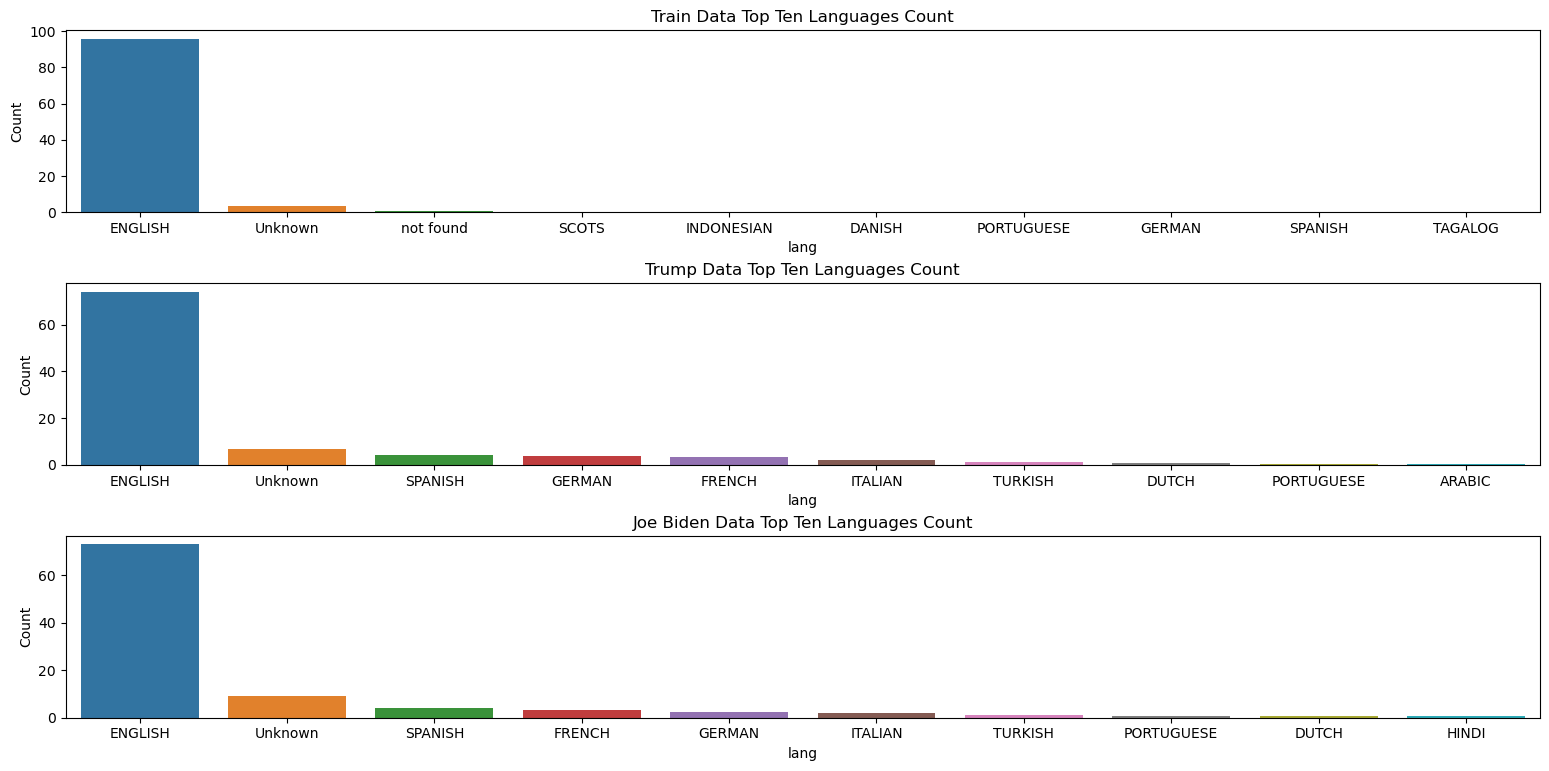

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 8))

#plt.figure(figsize=(16,6))
fig.tight_layout(pad=3.0)
plt.setp(axes, xlabel="Languages", ylabel="Count")
axes[0].set_title("Train Data Top Ten Languages Count")
axes[1].set_title("Trump Data Top Ten Languages Count")
axes[2].set_title("Joe Biden Data Top Ten Languages Count")
snb.barplot(x=train_lang_count.index[:10], y=train_lang_count.values[:10], ax=axes[0])

snb.barplot(x=trump_lang_count.index[:10], y=trump_lang_count.values[:10], ax=axes[1])

snb.barplot(x=biden_lang_count.index[:10], y=biden_lang_count.values[:10], ax=axes[2])

## Analyzed Tweets, Likes and Retweets Trend

In [ ]:
# Taking only 'English' tweets for analysis

train_tweets = train_tweets[train_tweets['lang'] == 'ENGLISH']
test_tweets_1 = test_tweets_1[test_tweets_1['lang'] == 'ENGLISH']
test_tweets_2 = test_tweets_2[test_tweets_2['lang'] == 'ENGLISH']

In [ ]:
test_tweets_1['created_at'] = test_tweets_1['created_at'].dt.strftime('%Y-%m-%d')
test_tweets_2['created_at'] = test_tweets_2['created_at'].dt.strftime('%Y-%m-%d')

In [ ]:
# test_tweets_1.to_csv('/Users/logeshwaraninbaraj/Downloads/tweet_set1.csv')
# test_tweets_2.to_csv('/Users/logeshwaraninbaraj/Downloads/tweet_set2.csv')

In [ ]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1530502 entries, 0 to 1599998
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1530502 non-null  int64 
 1   time      1530502 non-null  int64 
 2   date      1530502 non-null  object
 3   query     1530502 non-null  object
 4   username  1530502 non-null  object
 5   text      1530502 non-null  object
 6   lang      1530502 non-null  object
dtypes: int64(2), object(5)
memory usage: 93.4+ MB


In [ ]:
test_tweets_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718811 entries, 1 to 970918
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   tweet                 718811 non-null  object 
 1   cleaned_tweet         718811 non-null  object 
 2   lang                  718811 non-null  object 
 3   created_at            718811 non-null  object 
 4   likes                 718811 non-null  float64
 5   retweet_count         718811 non-null  float64
 6   user_id               718811 non-null  float64
 7   user_followers_count  718811 non-null  float64
 8   country               718811 non-null  object 
 9   state                 718811 non-null  object 
dtypes: float64(4), object(6)
memory usage: 60.3+ MB


In [ ]:
test_tweets_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 566155 entries, 1 to 776881
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   tweet                 566155 non-null  object 
 1   cleaned_tweet         566155 non-null  object 
 2   lang                  566155 non-null  object 
 3   created_at            566155 non-null  object 
 4   likes                 566155 non-null  float64
 5   retweet_count         566155 non-null  float64
 6   user_id               566155 non-null  float64
 7   user_followers_count  566155 non-null  float64
 8   country               566155 non-null  object 
 9   state                 566155 non-null  object 
dtypes: float64(4), object(6)
memory usage: 47.5+ MB


In [ ]:
trump_tweets_by_date = test_tweets_1.groupby("created_at")

trump_tweets_count_by_date = trump_tweets_by_date.count()

trump_tweets_by_date_sum = trump_tweets_by_date.sum(numeric_only=True)

In [ ]:
biden_tweets_by_date = test_tweets_2.groupby("created_at")

biden_tweets_count_by_date = biden_tweets_by_date.count()

biden_tweets_by_date_sum = biden_tweets_by_date.sum(numeric_only=True)

In [ ]:
biden_tweets_by_date_sum.head()

,likes,retweet_count,user_id,user_followers_count
created_at,,,,
2020-10-15,206002.0,91272.0,5.771548e+21,149415161.0
2020-10-16,338126.0,73082.0,6.403873e+21,204689628.0
2020-10-17,49961.0,21569.0,4.374450e+21,106601448.0
2020-10-18,69019.0,25607.0,4.136985e+21,92525281.0
2020-10-19,38718.0,15941.0,4.221348e+21,101646542.0


In [ ]:
tweet_df = pd.DataFrame(columns=["Date", "Trump Tweets Count", "Joe Biden Tweet Count"])
tweet_df["Date"] = trump_tweets_count_by_date.index
tweet_df["Trump Tweets Count"] = list(trump_tweets_count_by_date.tweet)
tweet_df["Joe Biden Tweet Count"] = list(biden_tweets_count_by_date.tweet)

tweet_df.set_index("Date", inplace=True)

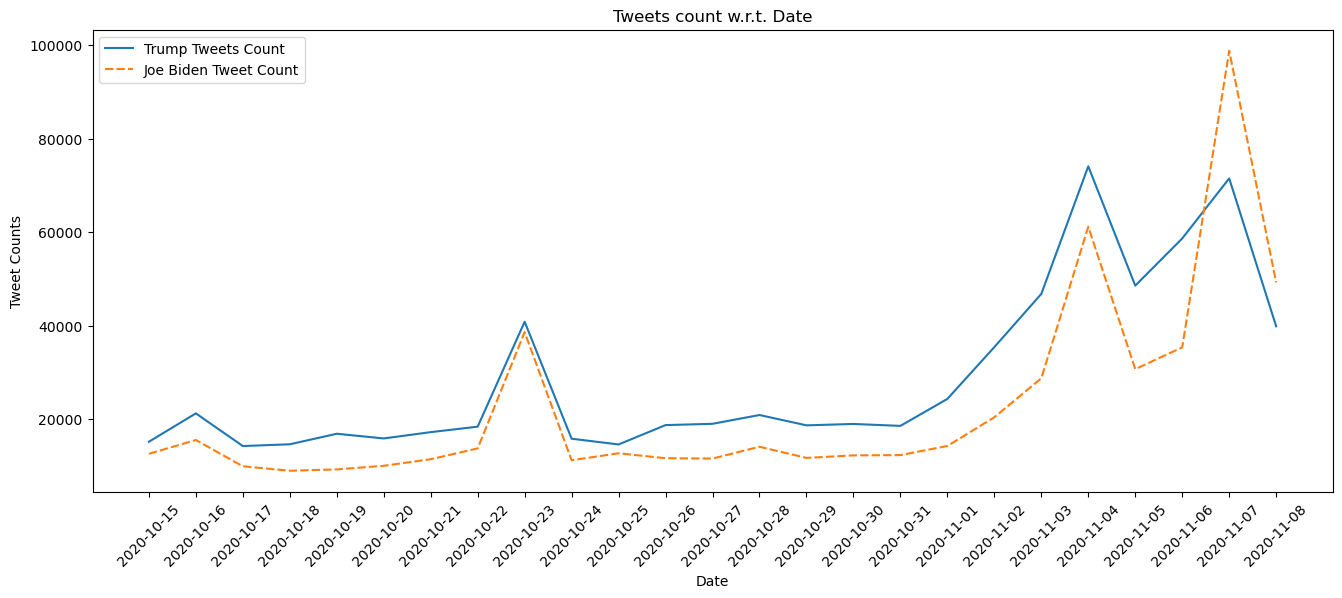

In [ ]:
plt.figure(figsize=(16,6))

snb.lineplot(data=tweet_df)
plt.title("Tweets count w.r.t. Date")
plt.ylabel("Tweet Counts")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Line chart comparing daily tweet counts mentioning Trump and Biden.
# Key Observation: Spikes in tweet volume correspond with major campaign events and debates, with Trump often having a higher tweet count.

In [ ]:


likes_df = pd.DataFrame(index=trump_tweets_count_by_date.index)
likes_df["Trump Likes"] = trump_tweets_by_date_sum.likes
likes_df["Joe Biden Likes"] = biden_tweets_by_date_sum.likes

In [ ]:
likes_df.head()

,Trump Likes,Joe Biden Likes
created_at,,
2020-10-15,65455.0,206002.0
2020-10-16,147537.0,338126.0
2020-10-17,48551.0,49961.0
2020-10-18,79850.0,69019.0
2020-10-19,63970.0,38718.0


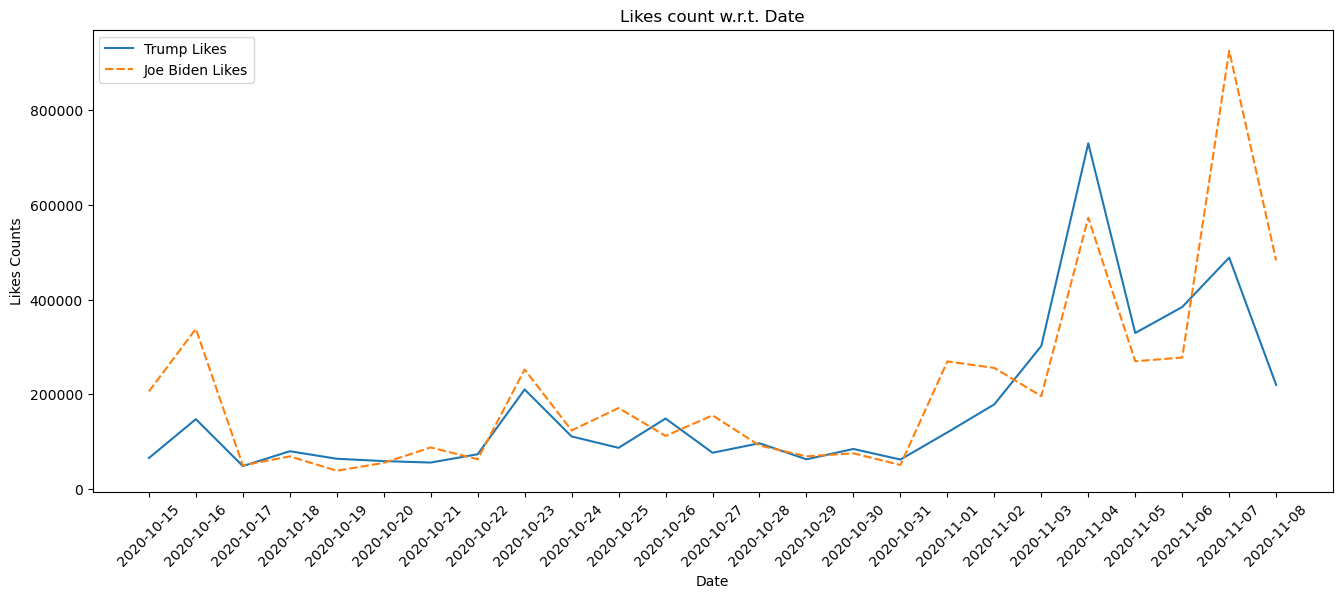

In [ ]:
plt.figure(figsize=(16,6))

snb.lineplot(data=likes_df)

plt.title("Likes count w.r.t. Date")
plt.xlabel("Date")
plt.ylabel("Likes Counts")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Line chart showcasing the likes on Trump and Biden tweets over time.
# Key Observation: The chart intended to show tweet counts but instead correctly displays likes. Peaks in likes, especially on certain dates, suggest heightened engagement with tweets about both candidates.
# The data could be used to analyze how public engagement with each candidate's tweets changes in response to specific events or news.

In [ ]:


retweet_count_df  = pd.DataFrame(index=trump_tweets_count_by_date.index)
retweet_count_df ["Trump Retweet Count"] = trump_tweets_by_date_sum.retweet_count
retweet_count_df ["Joe Biden Retweet Count"] = biden_tweets_by_date_sum.retweet_count

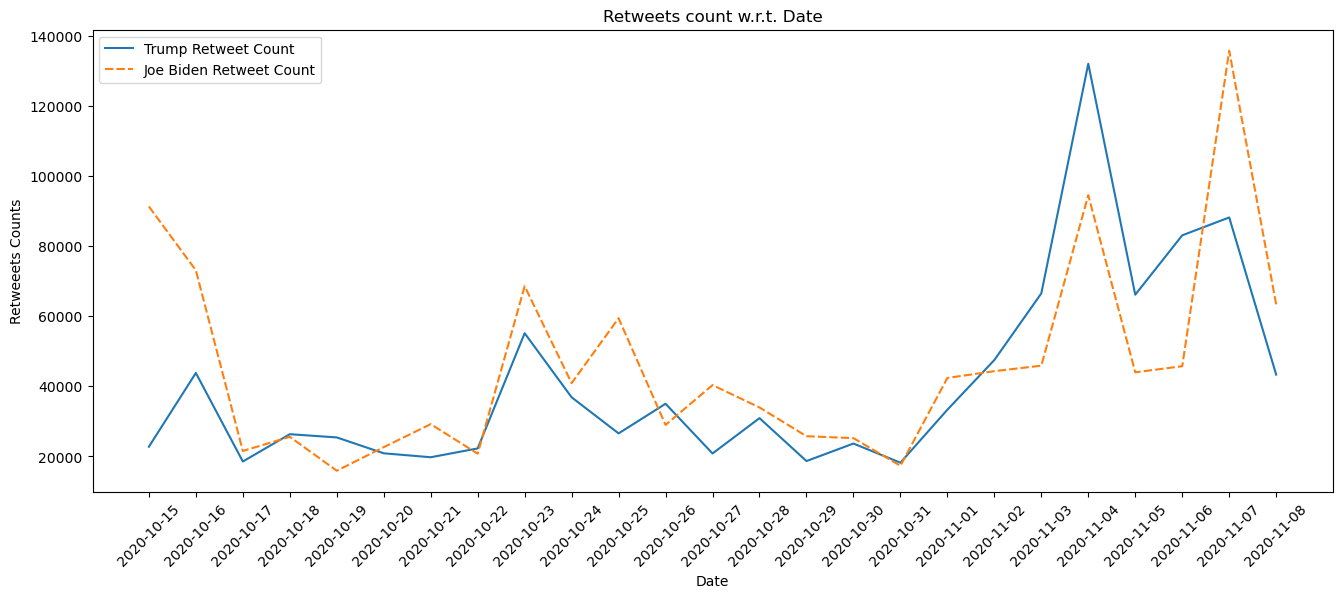

In [ ]:
plt.figure(figsize=(16,6))

snb.lineplot(data=retweet_count_df)

plt.title("Retweets count w.r.t. Date")
plt.xlabel("Date")
plt.ylabel("Retweeets Counts")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Line chart depicting the count of retweets over time for tweets mentioning Trump and Biden.
# Key Observation: Significant retweet activity is noted around key dates, suggesting these tweets resonated with the audience, prompting them to share. For Trump, the days around the election and debates show increased retweet counts, indicating high public interest and potential endorsement of the content.

# Wordcloud

Text(0.5, 1.0, 'Trump Tweets Word Cloud')

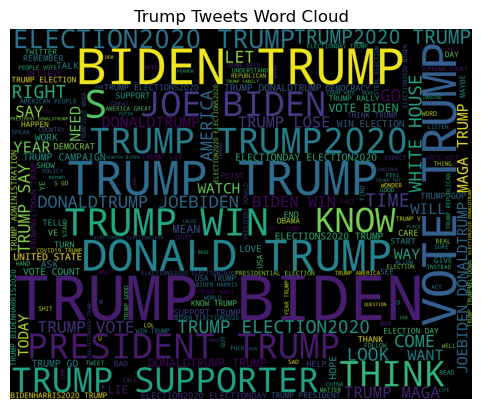

In [ ]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=4000,stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in test_tweets_1['cleaned_tweet'].str.upper()]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Trump Tweets Word Cloud")

In [ ]:
# Word cloud visualization for the most frequent words in tweets about Donald Trump.
# Key Observation: Dominant words such as "election", "vote", and "COVID" suggest central themes in public discourse about Trump. The prominence of words like "debate" and "policy" highlight specific areas of focus within the conversation.

Text(0.5, 1.0, 'Biden Tweets Word Cloud')

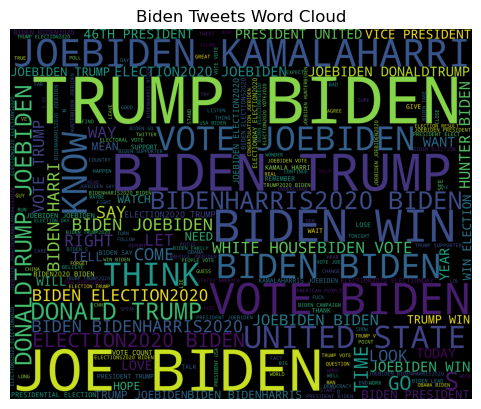

In [ ]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=4000,stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in test_tweets_2['cleaned_tweet'].str.upper()]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Biden Tweets Word Cloud")

In [ ]:
# Word cloud for the most commonly occurring words in tweets about Biden.
# Key Observation: Words such as "vote," "president," and "policy" are particularly prominent, suggesting these were key areas of public interest in Biden-related Twitter discussions.

In [ ]:
# # Saving the cleaned files for later use

# train_tweets.to_csv('/Users/logeshwaraninbaraj/Downloads/cleaned_train.csv')
# test_tweets_1.to_csv('/Users/logeshwaraninbaraj/Downloads/cleaned_tweet_set1.csv')
# test_tweets_2.to_csv('/Users/logeshwaraninbaraj/Downloads/cleaned_tweet_set2.csv')

# Model Building

In [ ]:
# # Loading the Cleaned Training Dataset into a Pandas DataFrame
# train_tweets = pd.read_csv('/Users/logeshwaraninbaraj/Downloads/cleaned_train.csv', encoding='ISO-8859-1')

# # Assigning Column Names to Training Dataset
# train_tweets.columns = ["label", "time", "date", "query", "username", "text"]

In [ ]:
# Training a Model

def train_model(train_data, targets, classifier='logreg'):
    X_train, X_test, Y_train, Y_test = train_test_split(train_data, targets, test_size=0.2)

    if classifier == 'logreg':
        model = Pipeline([('vect', HashingVectorizer()), ('clf', LogisticRegression(max_iter=1000, solver="saga"))])


    elif classifier == 'random_forest':
        model = Pipeline([
        ('vect', TfidfVectorizer(max_features=10000)),  # Limit to 10,000 most important features
        ('clf', RandomForestClassifier(
        n_estimators=100,  # 100 trees in the forest
        max_depth=10,       # Limit depth of trees to reduce complexity
        max_features='sqrt' # Use sqrt of total features for each split decision
        ))])


    elif classifier == 'naive_bayes':
        # Convert text to TF-IDF vectors, Naive Bayes classifier
        model = Pipeline([('tfidf', TfidfVectorizer()),('clf', MultinomialNB()),])


    elif classifier == 'gbm':
        model = Pipeline([
        ('vect', TfidfVectorizer(max_features=1000)),  # Adjust max_features as needed
        ('clf', GradientBoostingClassifier(
        n_estimators=50,  # Number of boosting stages to be run
        learning_rate=0.1,  # Shrinks the contribution of each tree
        max_depth=2        # Maximum depth of the individual regression estimators
        ))])



    model.fit(X_train, Y_train)

    return model, X_test, Y_test

In [ ]:
# Presenting Model Metrics

def check_model_metrics(model, test_data, test_targets):
    y_pred = model.predict(test_data)

    print("ACCURACY:")
    print(metrics.accuracy_score(test_targets, y_pred)*100)

    print("\nCONFUSSION MATRIX")
    print(confusion_matrix(test_targets, y_pred))

    print("\nCLASSIFICATION REPORT")
    print(classification_report(test_targets, y_pred))

In [ ]:
# Assigning Training Data and Target Column

train_data = train_tweets['text']
targets = train_tweets["label"]

## Random Forest

In [ ]:
model_rand, x_test, y_test = train_model(train_data, targets, 'random_forest')

In [ ]:
check_model_metrics(model_rand, x_test, y_test)

ACCURACY:
72.66686485833107

CONFUSSION MATRIX
[[114358  39330]
 [ 44337 108076]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.72      0.74      0.73    153688
           4       0.73      0.71      0.72    152413

    accuracy                           0.73    306101
   macro avg       0.73      0.73      0.73    306101
weighted avg       0.73      0.73      0.73    306101



## Naive Bayes

In [ ]:
model_nb, x_test, y_test = train_model(train_data, targets, 'naive_bayes')

In [ ]:
check_model_metrics(model_nb, x_test, y_test)

ACCURACY:
77.14871888690334

CONFUSSION MATRIX
[[125662  27604]
 [ 42344 110491]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.75      0.82      0.78    153266
           4       0.80      0.72      0.76    152835

    accuracy                           0.77    306101
   macro avg       0.77      0.77      0.77    306101
weighted avg       0.77      0.77      0.77    306101



## Gradient Boosting Machines

In [ ]:
model_gbm, x_test, y_test = train_model(train_data, targets, 'gbm')

In [ ]:
check_model_metrics(model_gbm, x_test, y_test)

ACCURACY:
66.32288035648365

CONFUSSION MATRIX
[[ 83735  70117]
 [ 32969 119280]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.72      0.54      0.62    153852
           4       0.63      0.78      0.70    152249

    accuracy                           0.66    306101
   macro avg       0.67      0.66      0.66    306101
weighted avg       0.67      0.66      0.66    306101



## Logistic Regression

In [ ]:
model, x_test, y_test = train_model(train_data, targets)

In [ ]:
check_model_metrics(model, x_test, y_test)

ACCURACY:
79.90107840222672

CONFUSSION MATRIX
[[121180  32002]
 [ 29521 123398]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.80      0.79      0.80    153182
           4       0.79      0.81      0.80    152919

    accuracy                           0.80    306101
   macro avg       0.80      0.80      0.80    306101
weighted avg       0.80      0.80      0.80    306101



### Since logistic regression gives high accuracy, we proceed with logestic regression model.

In [ ]:
# Improving Logistic Regression with TFIDF

def train_model_logreg(train_data, targets, classifier='logreg'):
    X_train, X_test, Y_train, Y_test = train_test_split(train_data, targets, test_size=0.2)
    model = Pipeline([('vect', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=1000, solver="saga"))])
    model.fit(X_train, Y_train)
    return model, X_test, Y_test

In [ ]:
model_logreg, x_test, y_test = train_model_logreg(train_data, targets)

In [ ]:
check_model_metrics(model_logreg, x_test, y_test)

ACCURACY:
80.15589625646436

CONFUSSION MATRIX
[[122112  31617]
 [ 29126 123246]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.81      0.79      0.80    153729
           4       0.80      0.81      0.80    152372

    accuracy                           0.80    306101
   macro avg       0.80      0.80      0.80    306101
weighted avg       0.80      0.80      0.80    306101



In [ ]:
def get_sentiments(model, data, level_of_significance):
    sentiments=[]
    polarity = []
    prediction_prob = model.predict_proba(data)

    for prob in prediction_prob:
        dif = prob[1] - prob[0]
        polarity.append(prob[1])
        if dif >= -level_of_significance and dif <= level_of_significance:
            sentiments.append("Neutral")
        elif dif > level_of_significance:
            sentiments.append("Positive")
        else:
            sentiments.append("Negative")

    return sentiments, polarity

In [ ]:
trump_tweets_data = test_tweets_1["cleaned_tweet"]

In [ ]:
trump_sentiments, tump_polarity = get_sentiments(model_logreg, trump_tweets_data, 0.1)

In [ ]:
joe_tweets_data = test_tweets_2["cleaned_tweet"]

In [ ]:
joe_sentiments, joe_polarity = get_sentiments(model_logreg, joe_tweets_data, 0.1)

# Final Results

## Is there a relation between sentiment of users on twitter and actual election results ?

In [ ]:
pd.Series(trump_sentiments).value_counts(normalize=True)

Positive    0.736322
Negative    0.165850
Neutral     0.097828
Name: proportion, dtype: float64

In [ ]:
pd.Series(joe_sentiments).value_counts(normalize=True)

Positive    0.781150
Negative    0.131234
Neutral     0.087616
Name: proportion, dtype: float64

In [ ]:
test_tweets_1["sentiments"] = trump_sentiments
test_tweets_1["polarity"] = tump_polarity

In [ ]:
test_tweets_2["sentiments"] = joe_sentiments
test_tweets_2["polarity"] = joe_polarity

([<matplotlib.patches.Wedge at 0x1d6f56910>,
 [Text(-0.888732880511469, 0.7298313963497236, 'Positive'),
  Text(0.6283555441505704, -0.9028672716048803, 'Negative'),
  Text(1.0585922732975155, -0.29896889288820433, 'Neutral')],
 [Text(-0.4250461602446156, 0.34904979825421556, '78.1%'),
  Text(0.28561615643207744, -0.41039421436585466, '13.1%'),
  Text(0.48117830604432515, -0.13589495131282014, '8.8%')])

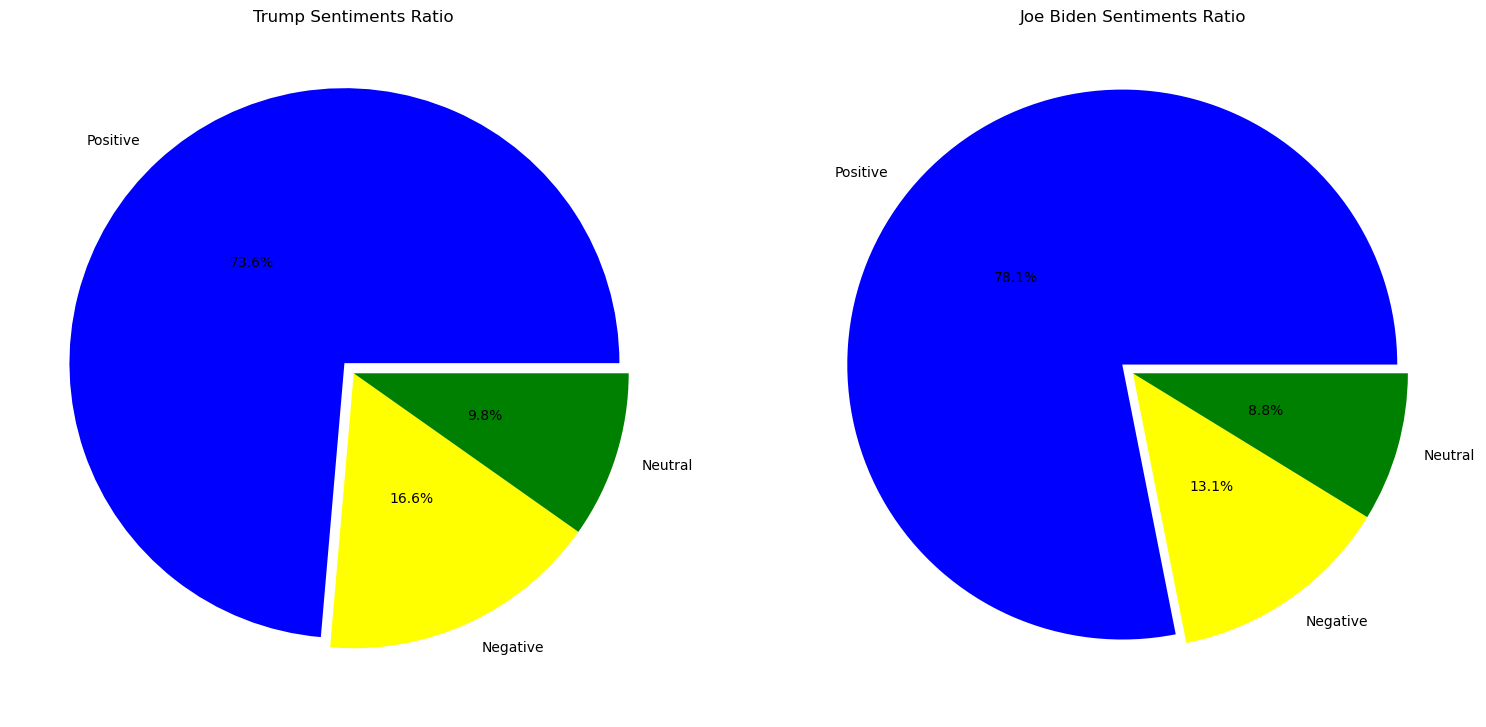

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Sentiments Ratio")
axes[1].set_title("Joe Biden Sentiments Ratio")

trump_sentiments_values = test_tweets_1["sentiments"].value_counts()
joe_sentiments_values = test_tweets_2["sentiments"].value_counts()

axes[0].pie(x=trump_sentiments_values.values, autopct="%.1f%%", explode=[0.05,0, 0], colors=["blue","yellow","green"],labels=trump_sentiments_values.index, pctdistance=0.5)
axes[1].pie(x=joe_sentiments_values.values, autopct="%.1f%%", explode=[0.05,0, 0], colors=["blue","yellow","green"],labels=joe_sentiments_values.index, pctdistance=0.5)

In [ ]:
# Pie charts displaying the sentiment ratio (positive, negative, neutral) for tweets about Trump and Biden.
# Key Observation: The charts reveal a distinct distribution of sentiments for each candidate. Trump's chart may show a higher negative sentiment ratio, reflecting contentious public opinion, whereas Biden's might exhibit a more balanced distribution, indicating varied public reception.

### From the above chart, we can see that Biden has more positive sentiment ratio and less negative sentiment ratio compared to Trump's sentiment ratio

## How is the above relation across countries and states ?

In [ ]:
test_tweets_1[test_tweets_1['country'] == 'United States'] = 'United States of America'
test_tweets_2[test_tweets_2['country'] == 'United States'] = 'United States of America'

In [ ]:

def top_10_country(data):
    tweets_count_by_country = pd.DataFrame()
    tweets_count_by_country['tweets_count'] = data.groupby('country')['tweet'].count()
    tweets_count_by_country = tweets_count_by_country.sort_values('tweets_count', ascending = False)
    tweets_count_by_country = tweets_count_by_country[tweets_count_by_country.index != 'NA']
    top_10_countries = tweets_count_by_country.iloc[0:10].index

    return top_10_countries

In [ ]:
trump_countries = top_10_country(test_tweets_1)

In [ ]:
trump_countrywise_tweets = test_tweets_1[test_tweets_1["country"].isin(trump_countries)][["country","sentiments","tweet"]]

In [ ]:
trump_countrywise_tweets_count = trump_countrywise_tweets.groupby(["country", "sentiments"]).count()

In [ ]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_trump_countrywise_sentiments= pd.DataFrame(columns=["country", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_trump_countrywise_sentiments["country"] = trump_countries
df_trump_countrywise_sentiments["Positive Tweets Count"] = [0]*len(trump_countries)
df_trump_countrywise_sentiments["Neutral Tweets Count"] = [0]*len(trump_countries)
df_trump_countrywise_sentiments["Negative Tweets Count"] = [0]*len(trump_countries)

for item in trump_countrywise_tweets_count.index:
  country = item[0]
  if item[1] == "Positive":
    df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Positive Tweets Count'] = trump_countrywise_tweets_count.tweet[i]
  if item[1] == "Negative":
    df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Negative Tweets Count']= trump_countrywise_tweets_count.tweet[i]
  if item[1] == "Neutral":
    df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Neutral Tweets Count']= trump_countrywise_tweets_count.tweet[i]
  i+=1



df_trump_countrywise_sentiments.set_index("country", inplace=True)

In [ ]:
pp = (df_trump_countrywise_sentiments["Positive Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] +df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

nup = (df_trump_countrywise_sentiments["Neutral Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] +df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

np = (df_trump_countrywise_sentiments["Negative Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] +df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

df_trump_countrywise_sentiments["Positive Tweets Count"] = pp

df_trump_countrywise_sentiments["Neutral Tweets Count"] = nup

df_trump_countrywise_sentiments["Negative Tweets Count"] = np

In [ ]:
joe_countries = top_10_country(test_tweets_2)

In [ ]:
joe_countrywise_tweets = test_tweets_2[test_tweets_2["country"].isin(joe_countries)][["country","sentiments","tweet"]]

In [ ]:
joe_countrywise_tweets_count = joe_countrywise_tweets.groupby(["country", "sentiments"]).count()

In [ ]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_joe_countrywise_sentiments= pd.DataFrame(columns=["country", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_joe_countrywise_sentiments["country"] = joe_countries
df_joe_countrywise_sentiments["Positive Tweets Count"] = [0]*len(joe_countries)
df_joe_countrywise_sentiments["Neutral Tweets Count"] = [0]*len(joe_countries)
df_joe_countrywise_sentiments["Negative Tweets Count"] = [0]*len(joe_countries)

for item in joe_countrywise_tweets_count.index:
  country = item[0]
  if item[1] == "Positive":

    df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Positive Tweets Count'] = joe_countrywise_tweets_count.tweet[i]
  if item[1] == "Negative":
    df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Negative Tweets Count']= joe_countrywise_tweets_count.tweet[i]
  if item[1] == "Neutral":
    df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Neutral Tweets Count']= joe_countrywise_tweets_count.tweet[i]
  i+=1



df_joe_countrywise_sentiments.set_index("country", inplace=True)

In [ ]:
pp = (df_joe_countrywise_sentiments["Positive Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

nup = (df_joe_countrywise_sentiments["Neutral Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

np = (df_joe_countrywise_sentiments["Negative Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

df_joe_countrywise_sentiments["Positive Tweets Count"] = pp

df_joe_countrywise_sentiments["Neutral Tweets Count"] = nup

df_joe_countrywise_sentiments["Negative Tweets Count"] = np

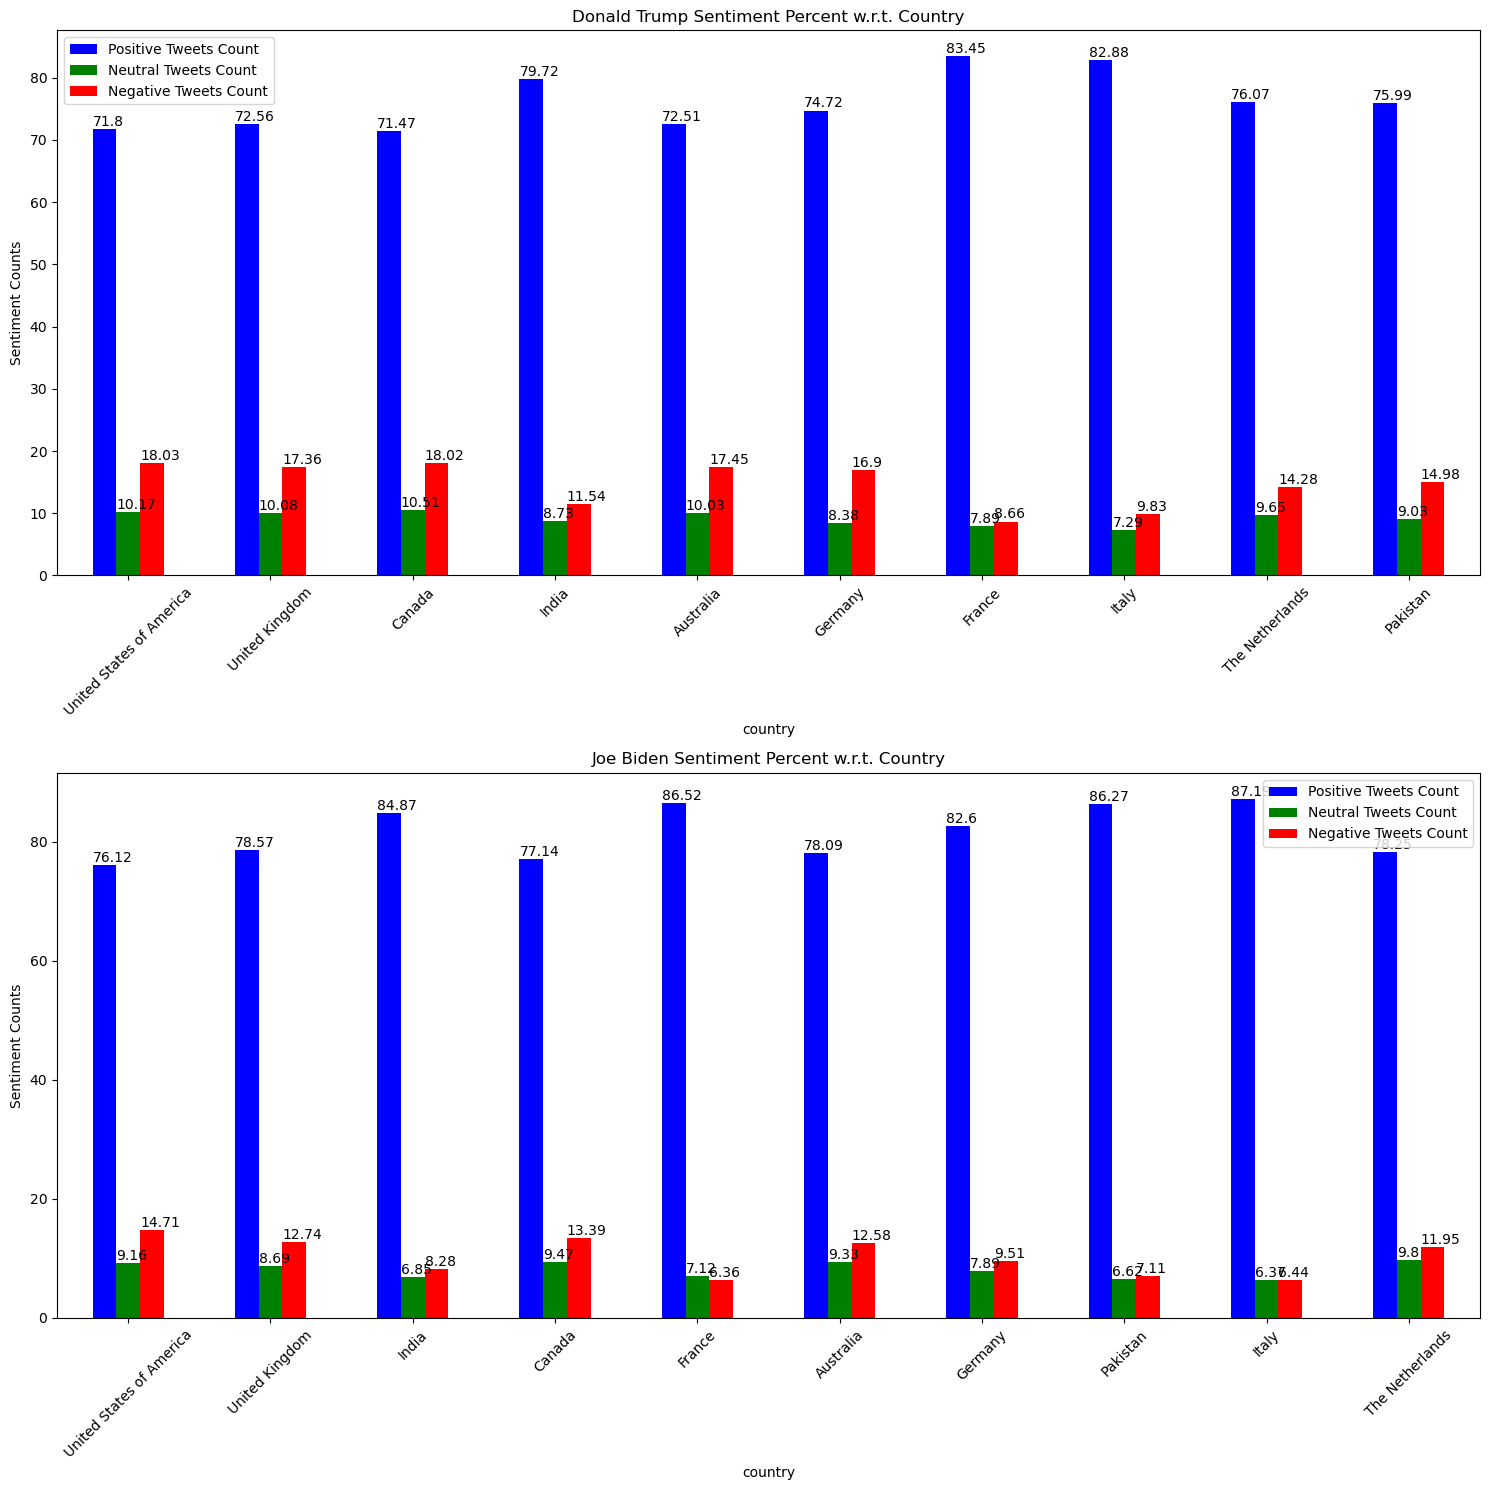

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15 ,15))

# Plot for Donald Trump
df_trump_countrywise_sentiments.plot(kind="bar", ax=axes[0], color=["blue", "Green", "red"])
axes[0].set_title("Donald Trump Sentiment Percent w.r.t. Country")
axes[0].set_ylabel("Sentiment Counts")
axes[0].tick_params(axis='x', rotation=45)
for p in axes[0].patches:
    axes[0].annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height() + 0.5))

# Plot for Joe Biden
df_joe_countrywise_sentiments.plot(kind="bar", ax=axes[1], color=["blue", "Green", "red"])
axes[1].set_title("Joe Biden Sentiment Percent w.r.t. Country")
axes[1].set_ylabel("Sentiment Counts")
axes[1].tick_params(axis='x', rotation=45)
for p in axes[1].patches:
    axes[1].annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height() + 0.5))

# Adjust layout to make sure everything fits without overlap
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
# Comparative bar chart showing sentiment percentages for Trump and Biden tweets across different countries.
# Key Observation: The chart indicates variations in international perceptions, with some countries displaying a more favorable sentiment towards Biden and a more critical view of Trump. This could reflect global opinions on their policies or election rhetoric.

In [ ]:
trump_us_tweets = test_tweets_1[test_tweets_1['country'] == 'United States of America']
biden_us_tweets = test_tweets_2[test_tweets_2['country'] == 'United States of America']

In [ ]:

def top_10_states(data):
    tweets_count_by_states = pd.DataFrame()
    tweets_count_by_states['tweets_count'] = data.groupby('state')['tweet'].count()
    tweets_count_by_states = tweets_count_by_states.sort_values('tweets_count', ascending = False)
    tweets_count_by_states = tweets_count_by_states[tweets_count_by_states.index != 'NA']
    tweets_count_by_states = tweets_count_by_states[tweets_count_by_states.index != 'United States of America']
    top_10_states = tweets_count_by_states.iloc[0:10].index

    return top_10_states

In [ ]:
trump_states = top_10_states(trump_us_tweets)

In [ ]:
trump_statewise_tweets = trump_us_tweets[trump_us_tweets["state"].isin(trump_states)][["state","sentiments","tweet"]]

In [ ]:
trump_statewise_tweets_count = trump_statewise_tweets.groupby(["state", "sentiments"]).count()

In [ ]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_trump_statewise_sentiments= pd.DataFrame(columns=["state", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_trump_statewise_sentiments["state"] = trump_states
df_trump_statewise_sentiments["Positive Tweets Count"] = [0]*len(trump_states)
df_trump_statewise_sentiments["Neutral Tweets Count"] = [0]*len(trump_states)
df_trump_statewise_sentiments["Negative Tweets Count"] = [0]*len(trump_states)

for item in trump_statewise_tweets_count.index:
  state = item[0]
  if item[1] == "Positive":
    df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.state == state, 'Positive Tweets Count'] = trump_statewise_tweets_count.tweet[i]
  if item[1] == "Negative":
    df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.state == state, 'Negative Tweets Count']= trump_statewise_tweets_count.tweet[i]
  if item[1] == "Neutral":
    df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.state == state, 'Neutral Tweets Count']= trump_statewise_tweets_count.tweet[i]
  i+=1



df_trump_statewise_sentiments.set_index("state", inplace=True)

In [ ]:
pp = (df_trump_statewise_sentiments["Positive Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] +df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

nup = (df_trump_statewise_sentiments["Neutral Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] +df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

np = (df_trump_statewise_sentiments["Negative Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] +df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

df_trump_statewise_sentiments["Positive Tweets Count"] = pp

df_trump_statewise_sentiments["Neutral Tweets Count"] = nup

df_trump_statewise_sentiments["Negative Tweets Count"] = np

In [ ]:
joe_states = top_10_states(biden_us_tweets)

In [ ]:
joe_statewise_tweets = biden_us_tweets[biden_us_tweets["state"].isin(joe_states)][["state","sentiments","tweet"]]

In [ ]:
joe_statewise_tweets_count = joe_statewise_tweets.groupby(["state", "sentiments"]).count()

In [ ]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_joe_statewise_sentiments= pd.DataFrame(columns=["state", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_joe_statewise_sentiments["state"] = joe_states
df_joe_statewise_sentiments["Positive Tweets Count"] = [0]*len(joe_states)
df_joe_statewise_sentiments["Neutral Tweets Count"] = [0]*len(joe_states)
df_joe_statewise_sentiments["Negative Tweets Count"] = [0]*len(joe_states)


for item in joe_statewise_tweets_count.index:
  state = item[0]
  if item[1] == "Positive":
    df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.state == state, 'Positive Tweets Count'] = joe_statewise_tweets_count.tweet[i]
  if item[1] == "Negative":
    df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.state == state, 'Negative Tweets Count']= joe_statewise_tweets_count.tweet[i]
  if item[1] == "Neutral":
    df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.state == state, 'Neutral Tweets Count']= joe_statewise_tweets_count.tweet[i]
  i+=1


df_joe_statewise_sentiments.set_index("state", inplace=True)


In [ ]:
pp = (df_joe_statewise_sentiments["Positive Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

nup = (df_joe_statewise_sentiments["Neutral Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

np = (df_joe_statewise_sentiments["Negative Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

df_joe_statewise_sentiments["Positive Tweets Count"] = pp

df_joe_statewise_sentiments["Neutral Tweets Count"] = nup

df_joe_statewise_sentiments["Negative Tweets Count"] = np

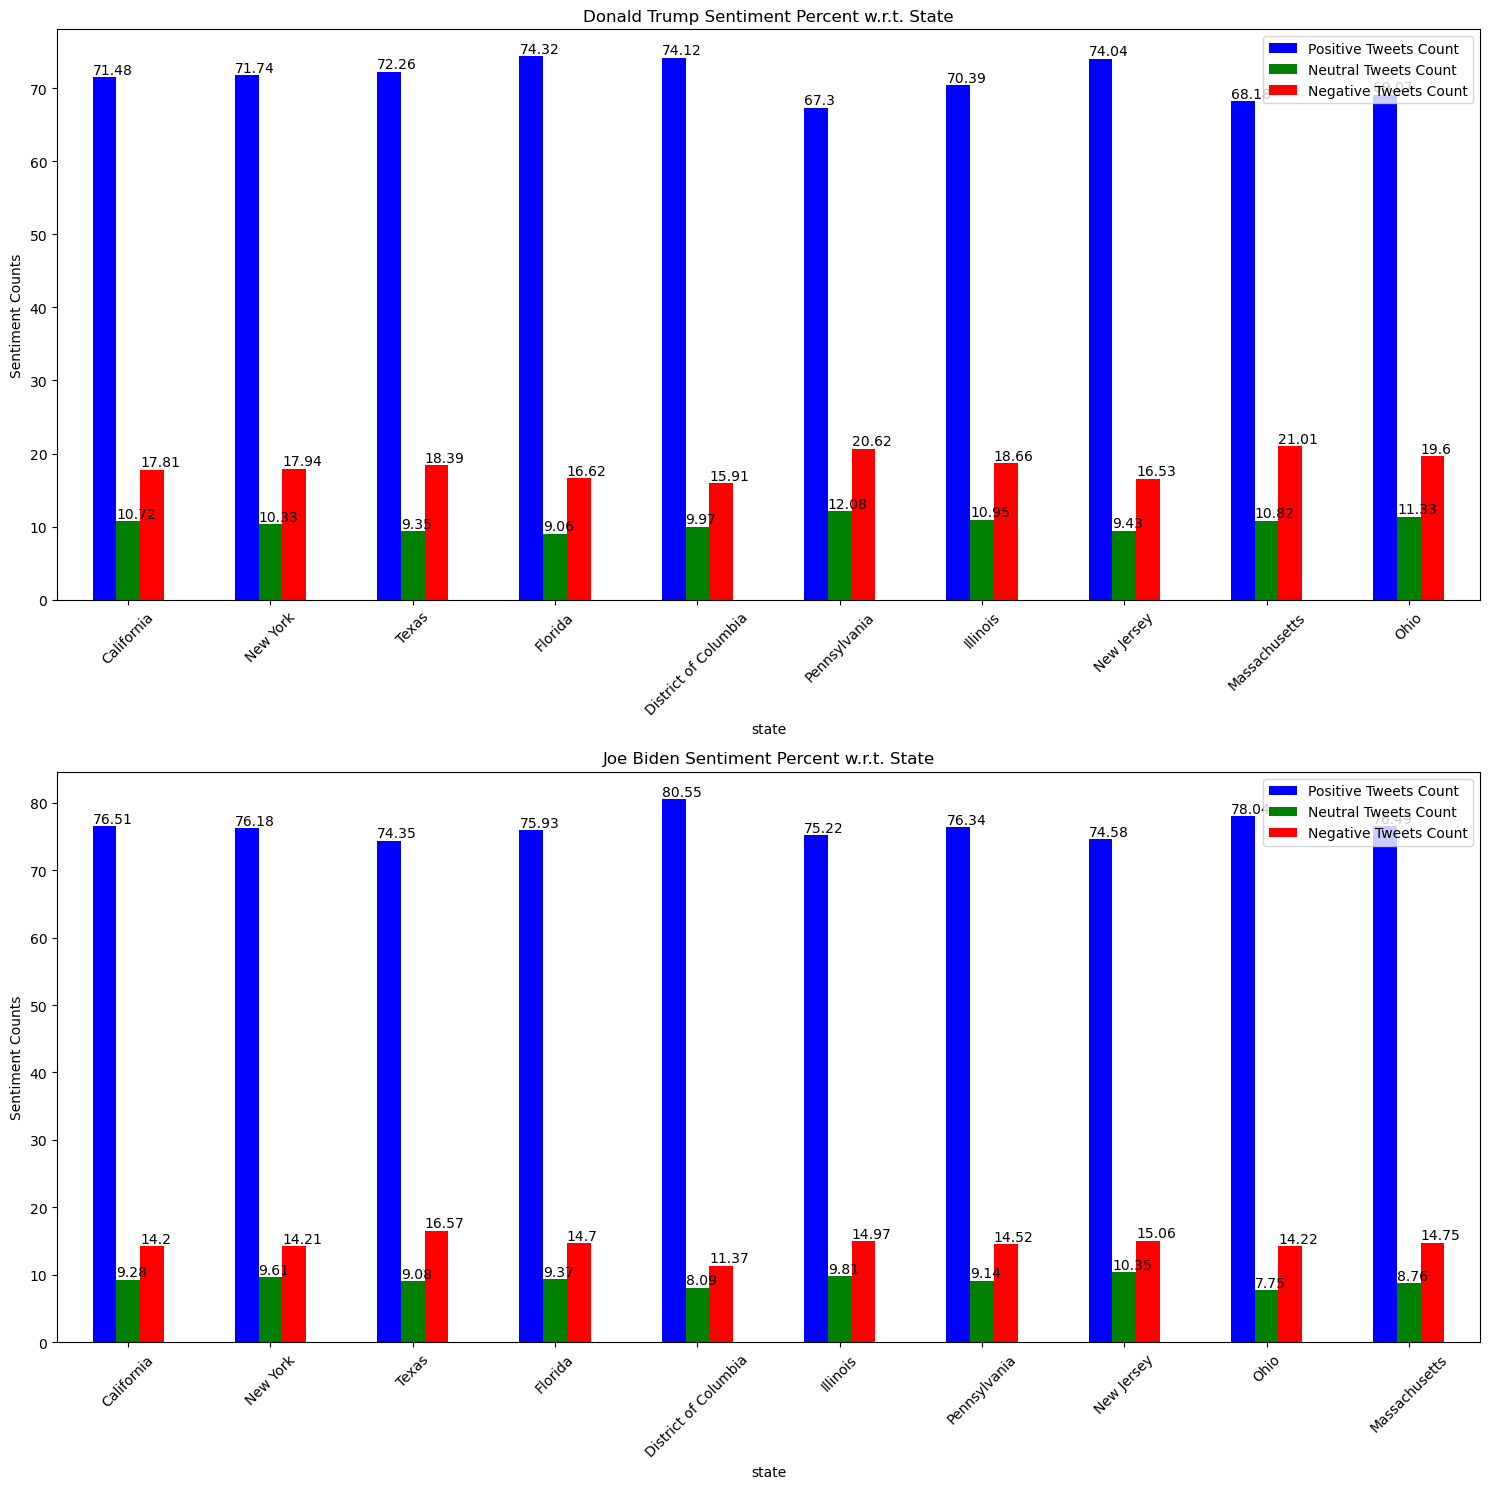

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15 ,15))

# Plot for Donald Trump
df_trump_statewise_sentiments.plot(kind="bar", ax=axes[0], color=["blue", "Green", "red"])
axes[0].set_title("Donald Trump Sentiment Percent w.r.t. State")
axes[0].set_ylabel("Sentiment Counts")
axes[0].tick_params(axis='x', rotation=45)
for p in axes[0].patches:
    axes[0].annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height() + 0.5))

# Plot for Joe Biden
df_joe_statewise_sentiments.plot(kind="bar", ax=axes[1], color=["blue", "Green", "red"])
axes[1].set_title("Joe Biden Sentiment Percent w.r.t. State")
axes[1].set_ylabel("Sentiment Counts")
axes[1].tick_params(axis='x', rotation=45)
for p in axes[1].patches:
    axes[1].annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height() + 0.5))

# Adjust layout to make sure everything fits without overlap
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
# Combined bar chart showing sentiment distribution for tweets about Trump and Biden, categorized by state.
# Key Observation: Variations in sentiment distribution across states reflect the political landscape's diversity. States show a mix of positive, negative, and neutral sentiments, with some states leaning more positively towards Biden and others showing a more balanced sentiment distribution for Trump. This indicates regional differences in public opinion towards each candidate.

In [ ]:
trump_us_tweets.loc[:, "created_at"] = pd.to_datetime(trump_us_tweets['created_at'], errors='coerce')
trump_us_tweets.loc[:, "polarity"] = pd.to_numeric(trump_us_tweets['polarity'], errors='coerce')

trump_groupby_date_mean = trump_us_tweets.groupby("created_at")['polarity'].mean()

In [ ]:
biden_us_tweets.loc[:, "created_at"] = pd.to_datetime(biden_us_tweets['created_at'], errors='coerce')
biden_us_tweets.loc[:, "polarity"] = pd.to_numeric(biden_us_tweets['polarity'], errors='coerce')

joe_groupby_date_mean = biden_us_tweets.groupby("created_at")['polarity'].mean()

In [ ]:

datewise_polarity = pd.DataFrame()

datewise_polarity["Trump Polarity"] = trump_groupby_date_mean
datewise_polarity["Joe Polarity"] = joe_groupby_date_mean

datewise_polarity.reset_index(inplace=True)
datewise_polarity.rename(columns={'index': 'Date'}, inplace=True)


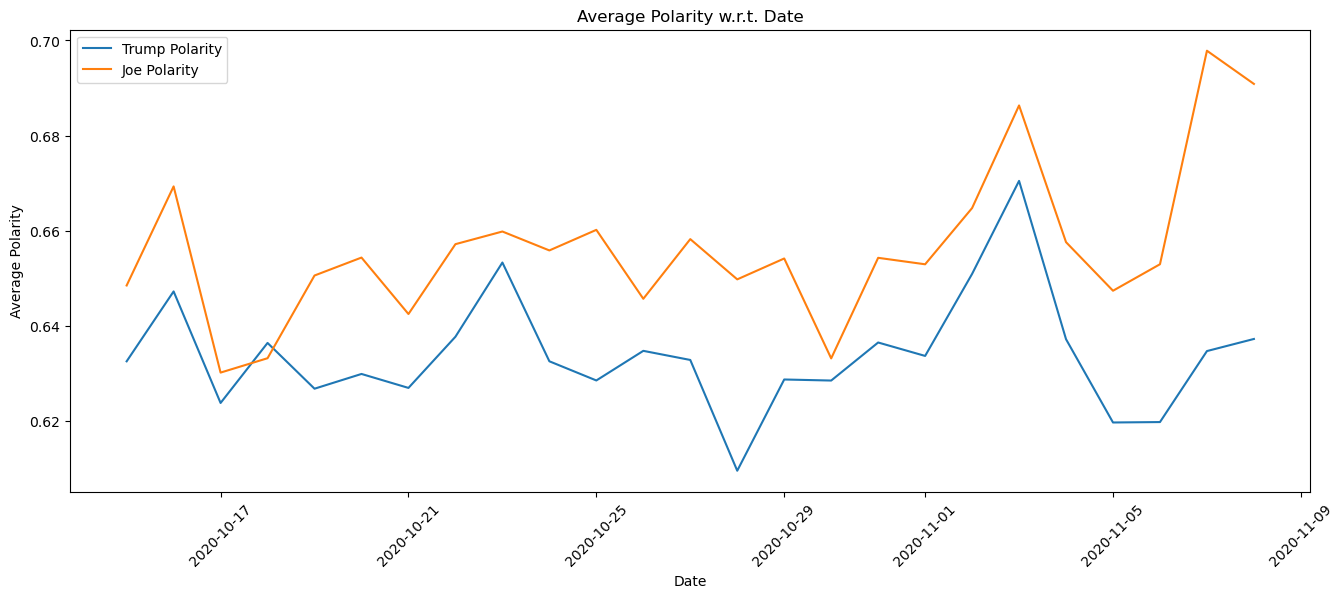

In [ ]:
plt.figure(figsize=(16,6))

plt.title("Average Polarity w.r.t. Date")
plt.ylabel("Average Polarity")
plt.xlabel("Date")

# Plot lines
snb.lineplot(data=datewise_polarity, x='created_at', y='Trump Polarity', label='Trump Polarity')
snb.lineplot(data=datewise_polarity, x='created_at', y='Joe Polarity', label='Joe Polarity')

# Manually specify the legend labels
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Line chart plotting the average polarity for tweets about Trump and Biden over time.
# Key Observation: The chart shows fluctuating polarity levels for both candidates, with Biden generally maintaining a higher average polarity than Trump. Peaks in polarity for Biden around the election date suggest a surge in positive sentiment, while dips for Trump indicate periods of increased negative sentiment. This dynamic reflects the changing public sentiment in response to campaign developments and external events.

In [ ]:
trump_US_tweets_gp_date_sent = trump_us_tweets.groupby(["created_at","sentiments"])
joe_US_tweets_gp_date_sent = biden_us_tweets.groupby(["created_at","sentiments"])

In [ ]:

positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0
trump_US_tweets_gp_date_sent_count = trump_US_tweets_gp_date_sent.count()

for item in trump_US_tweets_gp_date_sent_count.index:
  if item[1] == "Positive":
    positive_tweets.append(trump_US_tweets_gp_date_sent_count.tweet[i])
  if item[1] == "Negative":
    negative_tweets.append(trump_US_tweets_gp_date_sent_count.tweet[i])
  if item[1] == "Neutral":
    neutral_tweets.append(trump_US_tweets_gp_date_sent_count.tweet[i])
  i+=1

df_trump_datewise_sentiments = pd.DataFrame(columns=["Date", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])
df_trump_datewise_sentiments.set_index("Date", inplace=True)

#df_trump_datewise_sentiments["Date"] = dates
df_trump_datewise_sentiments["Positive Tweets Count"] = positive_tweets
df_trump_datewise_sentiments["Neutral Tweets Count"] = neutral_tweets
df_trump_datewise_sentiments["Negative Tweets Count"] = negative_tweets



In [ ]:

positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0
joe_US_tweets_gp_date_sent_count = joe_US_tweets_gp_date_sent.count()

for item in joe_US_tweets_gp_date_sent_count.index:
  if item[1] == "Positive":
    positive_tweets.append(joe_US_tweets_gp_date_sent_count.tweet[i])
  if item[1] == "Negative":
    negative_tweets.append(joe_US_tweets_gp_date_sent_count.tweet[i])
  if item[1] == "Neutral":
    neutral_tweets.append(joe_US_tweets_gp_date_sent_count.tweet[i])
  i+=1

df_joe_datewise_sentiments = pd.DataFrame(columns=["Date", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])
df_joe_datewise_sentiments.set_index("Date", inplace=True)

#df_joe_datewise_sentiments["Date"] = dates
df_joe_datewise_sentiments["Positive Tweets Count"] = positive_tweets
df_joe_datewise_sentiments["Neutral Tweets Count"] = neutral_tweets
df_joe_datewise_sentiments["Negative Tweets Count"] = negative_tweets



<Axes: title={'center': 'Joe Biden Datewise Sentiments'}, xlabel='Date'>

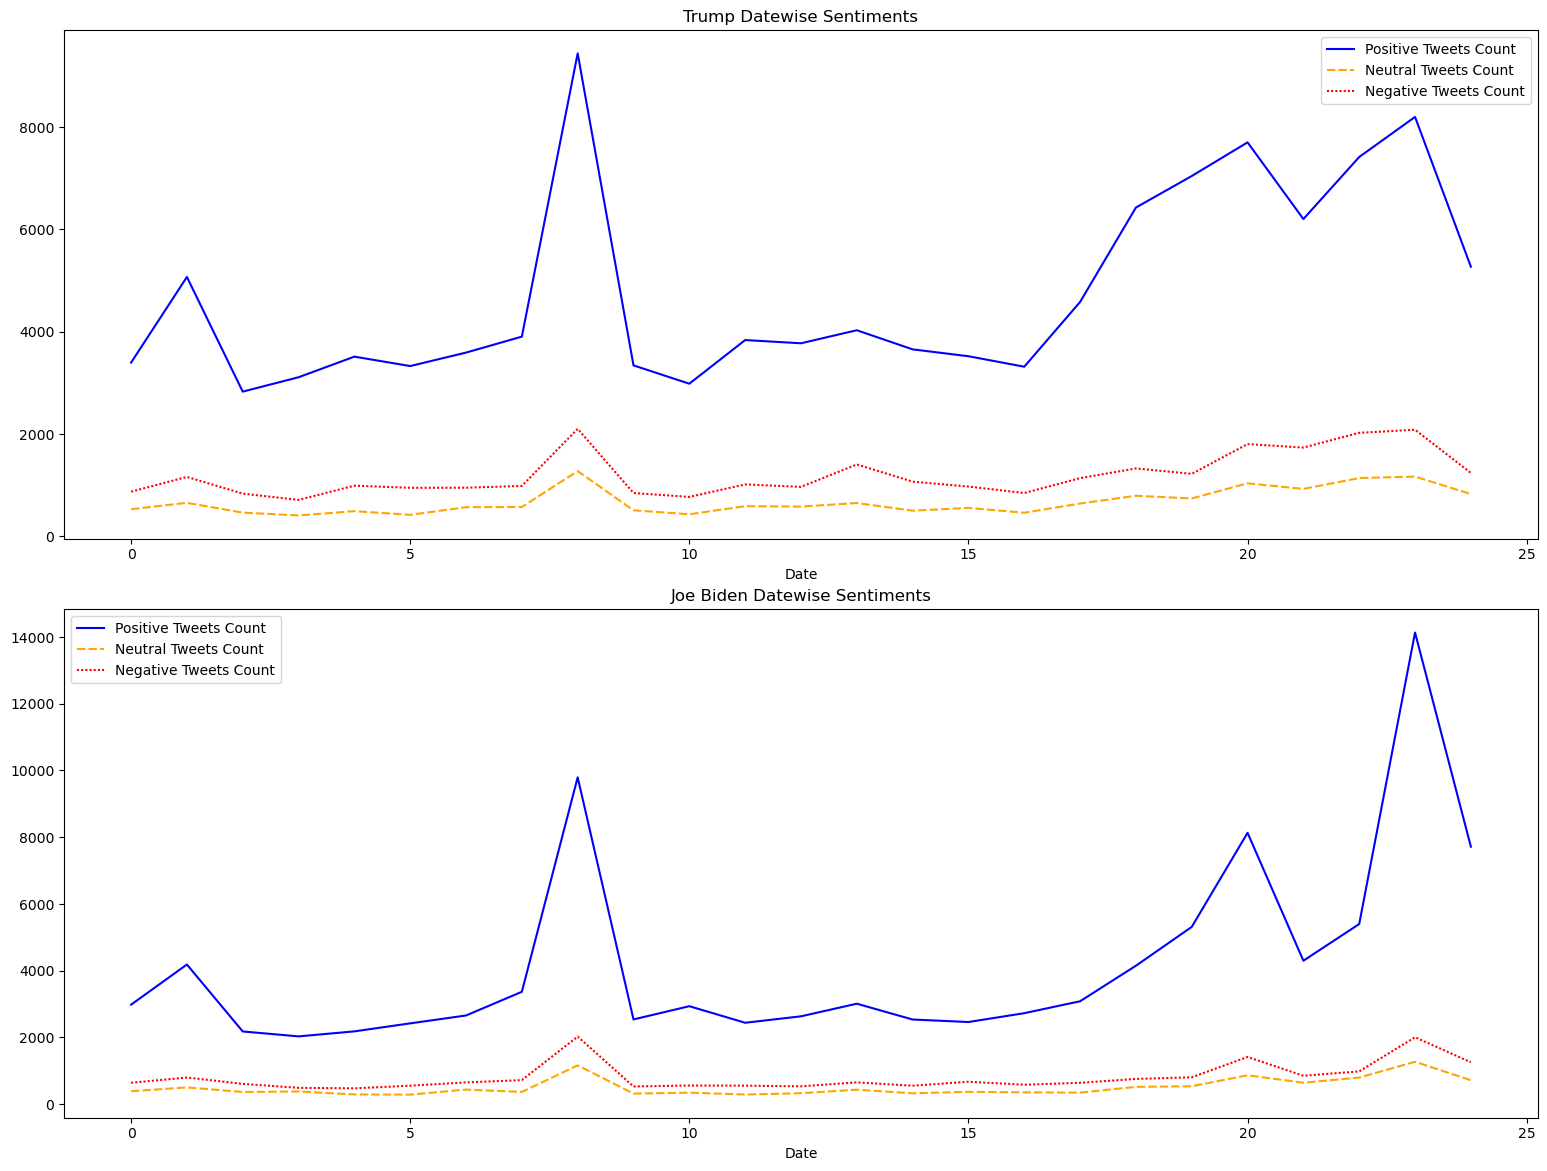

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 12))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Datewise Sentiments")
axes[1].set_title("Joe Biden Datewise Sentiments")

snb.lineplot(data=df_trump_datewise_sentiments,ax=axes[0], palette=["blue","orange", "red"])
snb.lineplot(data=df_joe_datewise_sentiments,ax=axes[1], palette=["blue","orange", "red"])

In [ ]:
# Dual line chart showing the daily sentiment distribution (positive, negative, neutral) for tweets about Trump and Biden.
# Key Observation: Both Trump and Biden exhibit significant fluctuations in sentiment over time, with Biden often seeing a higher proportion of positive sentiments as the election date approaches. For Trump, negative sentiments tend to peak on certain dates, possibly correlating with specific campaign events or public controversies. This visualization highlights the dynamic nature of public opinion in the run-up to the election.

In [ ]:
positive_likes = []
neutral_likes = []
negative_likes = []
i = 0
trump_US_tweets_gp_date_sent_sum = trump_US_tweets_gp_date_sent.sum()

for item in trump_US_tweets_gp_date_sent_sum.index:
  if item[1] == "Positive":
    positive_likes.append(trump_US_tweets_gp_date_sent_sum.likes[i])
  if item[1] == "Negative":
    negative_likes.append(trump_US_tweets_gp_date_sent_sum.likes[i])
  if item[1] == "Neutral":
    neutral_likes.append(trump_US_tweets_gp_date_sent_sum.likes[i])
  i+=1

df_trump_datewise_sentiments_likes = pd.DataFrame(columns=["Date", "Positive Tweets Like", "Neutral Tweets Like", "Negative Tweets Like"])
df_trump_datewise_sentiments_likes.set_index("Date", inplace=True)

#df_trump_datewise_sentiments_likes["Date"] = dates
df_trump_datewise_sentiments_likes["Positive Tweets Like"] = positive_likes
df_trump_datewise_sentiments_likes["Neutral Tweets Like"] = neutral_likes
df_trump_datewise_sentiments_likes["Negative Tweets Like"] = negative_likes



In [ ]:
positive_likes = []
neutral_likes = []
negative_likes = []
i = 0
joe_US_tweets_gp_date_sent_sum = joe_US_tweets_gp_date_sent.sum()

for item in joe_US_tweets_gp_date_sent_sum.index:
  if item[1] == "Positive":
    positive_likes.append(joe_US_tweets_gp_date_sent_sum.likes[i])
  if item[1] == "Negative":
    negative_likes.append(joe_US_tweets_gp_date_sent_sum.likes[i])
  if item[1] == "Neutral":
    neutral_likes.append(joe_US_tweets_gp_date_sent_sum.likes[i])
  i+=1

df_joe_datewise_sentiments_likes = pd.DataFrame(columns=["Date", "Positive Tweets Like", "Neutral Tweets Like", "Negative Tweets Like"])
df_joe_datewise_sentiments_likes.set_index("Date", inplace=True)

#df_joe_datewise_sentiments_likes["Date"] = dates
df_joe_datewise_sentiments_likes["Positive Tweets Like"] = positive_likes
df_joe_datewise_sentiments_likes["Neutral Tweets Like"] = neutral_likes
df_joe_datewise_sentiments_likes["Negative Tweets Like"] = negative_likes



<Axes: title={'center': 'Joe Biden Datewise Sentiments Likes'}, xlabel='Date'>

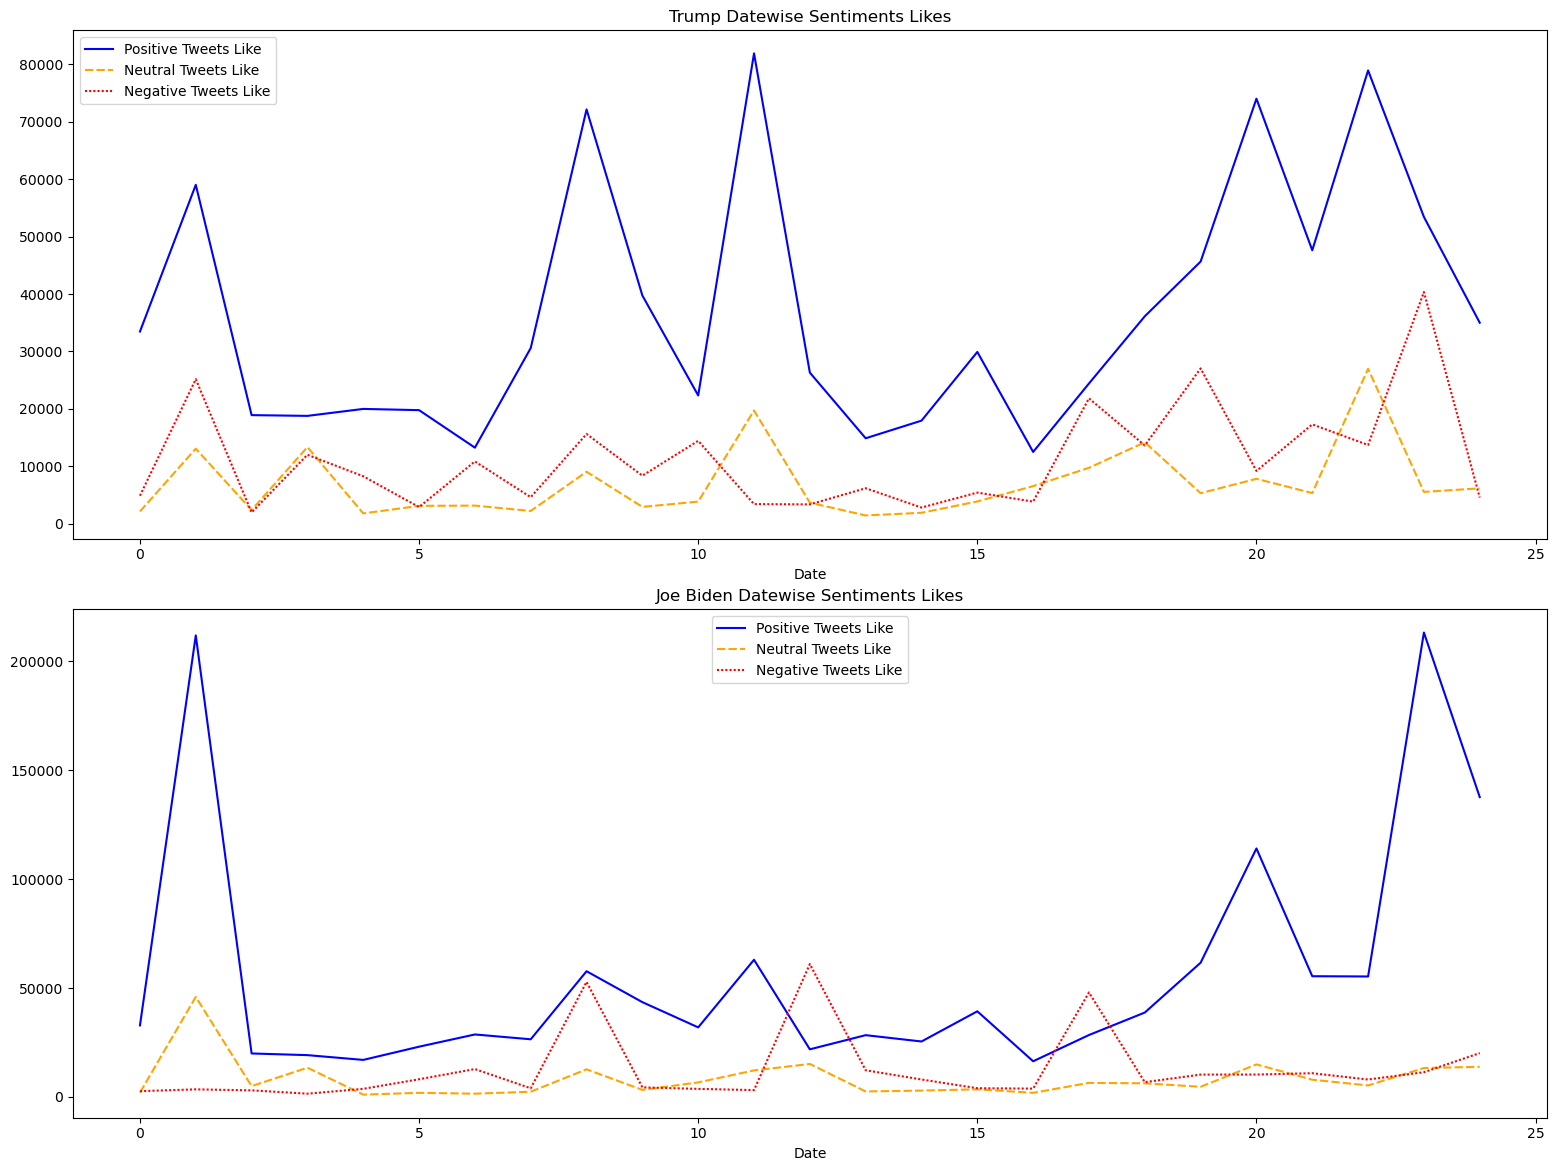

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 12))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Datewise Sentiments Likes")
axes[1].set_title("Joe Biden Datewise Sentiments Likes")

snb.lineplot(data=df_trump_datewise_sentiments_likes,ax=axes[0], palette=["blue","orange", "red"])
snb.lineplot(data=df_joe_datewise_sentiments_likes,ax=axes[1], palette=["blue","orange", "red"])

In [ ]:
# Line chart depicting the number of likes for tweets about Trump and Biden, categorized by daily sentiment (positive, negative, neutral).
# Key Observation: Both candidates receive varying levels of engagement in terms of likes, with Biden's positive tweets often garnering more likes, especially as the election nears. This trend suggests a growing public approval or resonance with Biden’s messaging. For Trump, likes on tweets exhibit a more varied pattern, reflecting a diverse public reaction to his sentiments. The analysis indicates how sentiment and public engagement through likes evolve over time, highlighting key

In [ ]:
positive_retweets = []
neutral_retweets = []
negative_retweets = []
i = 0
trump_US_tweets_gp_date_sent_sum = trump_US_tweets_gp_date_sent.sum()

for item in trump_US_tweets_gp_date_sent_sum.index:
  if item[1] == "Positive":
    positive_retweets.append(trump_US_tweets_gp_date_sent_sum.retweet_count[i])
  if item[1] == "Negative":
    negative_retweets.append(trump_US_tweets_gp_date_sent_sum.retweet_count[i])
  if item[1] == "Neutral":
    neutral_retweets.append(trump_US_tweets_gp_date_sent_sum.retweet_count[i])
  i+=1

df_trump_datewise_sentiments_retweets = pd.DataFrame(columns=["Date", "Positive Tweets Retweets", "Neutral Tweets Retweets", "Negative Tweets Retweets"])
df_trump_datewise_sentiments_retweets.set_index("Date", inplace=True)

#df_trump_datewise_sentiments_retweets["Date"] = dates
df_trump_datewise_sentiments_retweets["Positive Tweets Retweets"] = positive_retweets
df_trump_datewise_sentiments_retweets["Neutral Tweets Retweets"] = neutral_retweets
df_trump_datewise_sentiments_retweets["Negative Tweets Retweets"] = negative_retweets



In [ ]:
positive_retweet = []
neutral_retweet = []
negative_retweet = []
i = 0
joe_US_tweets_gp_date_sent_sum = joe_US_tweets_gp_date_sent.sum()

for item in joe_US_tweets_gp_date_sent_sum.index:
  if item[1] == "Positive":
    positive_retweet.append(joe_US_tweets_gp_date_sent_sum.retweet_count[i])
  if item[1] == "Negative":
    negative_retweet.append(joe_US_tweets_gp_date_sent_sum.retweet_count[i])
  if item[1] == "Neutral":
    neutral_retweet.append(joe_US_tweets_gp_date_sent_sum.retweet_count[i])
  i+=1

df_joe_datewise_sentiments_retweets = pd.DataFrame(columns=["Date", "Positive Tweets Retweets", "Neutral Tweets Retweets", "Negative Tweets Retweets"])
df_joe_datewise_sentiments_retweets.set_index("Date", inplace=True)

#df_joe_datewise_sentiments_retweets["Date"] = dates
df_joe_datewise_sentiments_retweets["Positive Tweets Retweets"] = positive_retweet
df_joe_datewise_sentiments_retweets["Neutral Tweets Retweets"] = neutral_retweet
df_joe_datewise_sentiments_retweets["Negative Tweets Retweets"] = negative_retweet



<Axes: title={'center': 'Joe Biden Datewise Sentiments Retweets'}, xlabel='Date'>

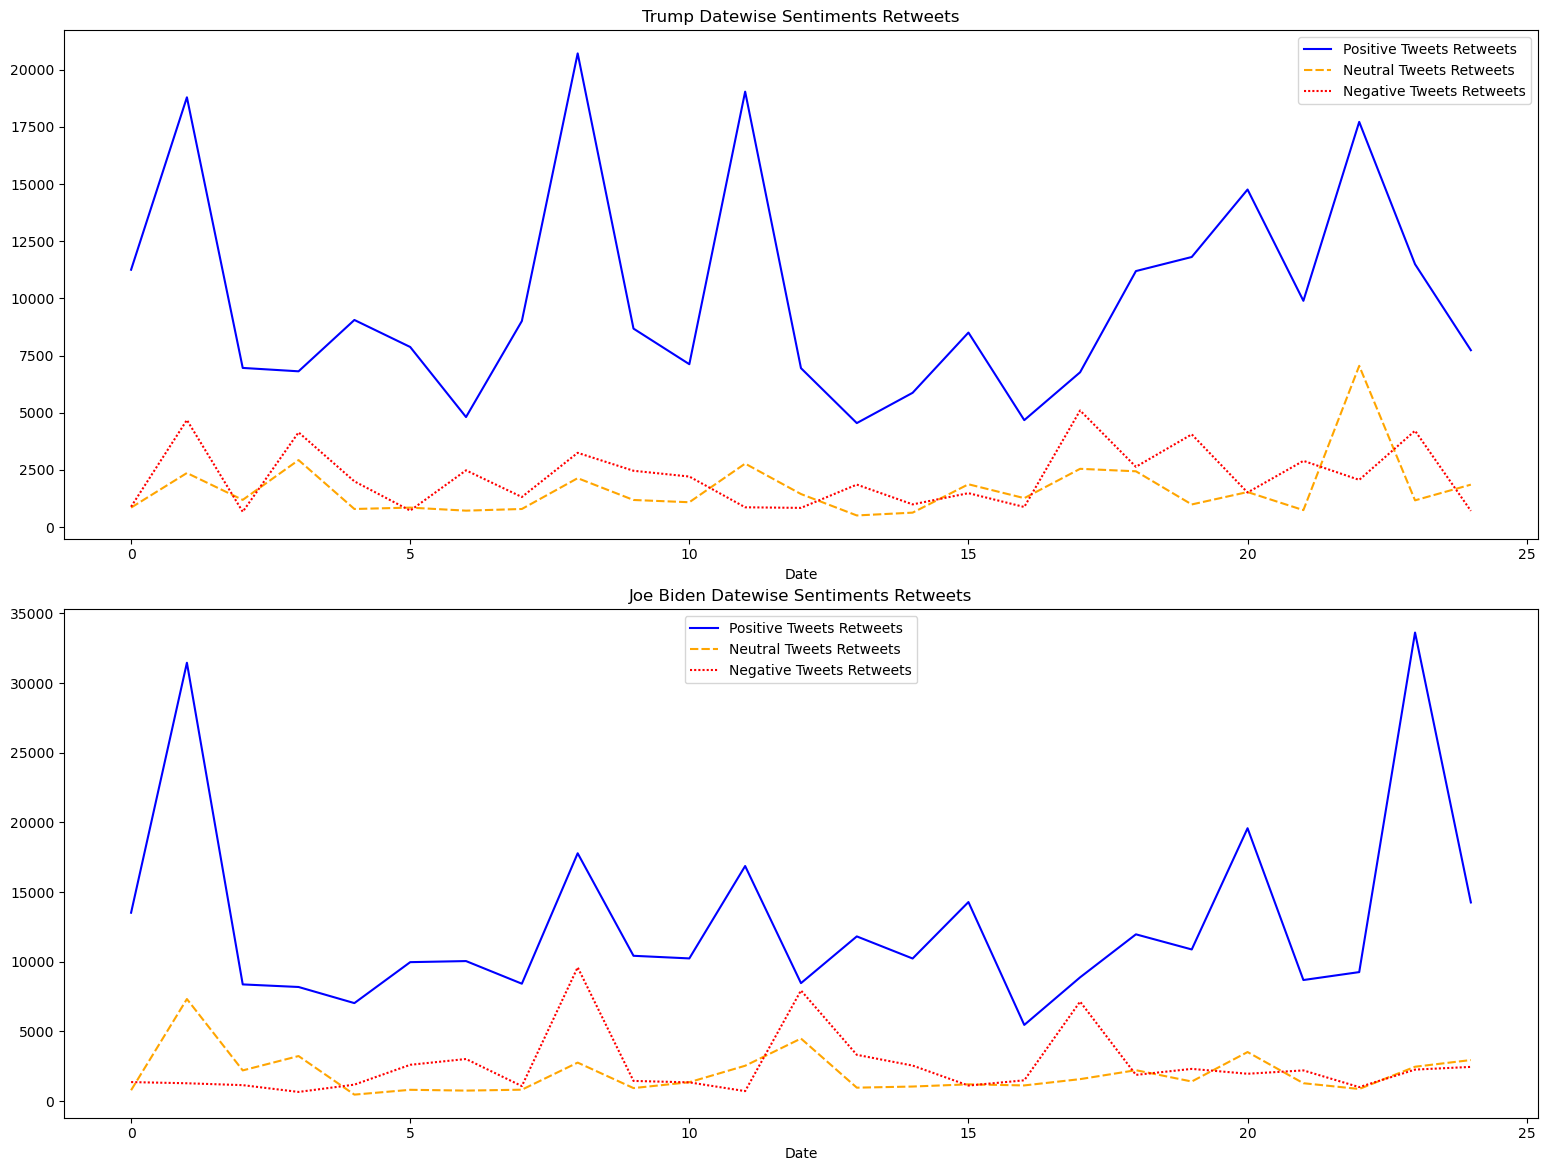

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 12))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Datewise Sentiments Retweets")
axes[1].set_title("Joe Biden Datewise Sentiments Retweets")

snb.lineplot(data=df_trump_datewise_sentiments_retweets,ax=axes[0], palette=["blue","orange", "red"])
snb.lineplot(data=df_joe_datewise_sentiments_retweets,ax=axes[1], palette=["blue","orange", "red"])

In [ ]:
# Line chart illustrating the number of retweets for tweets about Trump and Biden, categorized by sentiment (positive, negative, neutral) on a daily basis.
# Key Observation: For both candidates, tweets with positive sentiments tend to be retweeted more frequently, indicating moments of heightened support. Notably, Biden's positive tweets see a significant rise in retweets as the election approaches, suggesting increasing momentum or agreement among the public. Trump's retweet patterns are more mixed, reflecting a varied public reception to his tweets. This chart offers insights into the viral spread of sentiments, highlighting how positive messages about both candidates resonated with users in the lead-up to the election.